# Analysis of Model Performance:

---

Analysing results where we predict solvent or base.


Importing relevant packages:


In [1]:
import os
import sys

import matplotlib
import matplotlib.pyplot as plt
import polars as pl
import scikit_posthocs as sp
import seaborn as sns
from scipy.stats import levene, probplot

sys.path.append("../src")
from plots import (
    SYNTHWAVE_PALETTE,
    SYNTHWAVE_SINGLE_HUE_PALETTE,
    extend_palette,
    initiate_matplotlib_settings,
    add_titles,
    create_fig_legend,
    plot_top_k_accuracies,
    plot_alternative_classification_metrics,
)
from analysis import get_all_method_results, process_metrics_df

initiate_matplotlib_settings(
    font_path="/home/mball/Library/fonts/Lato",
    style_path="../reports/figure_styles.mplstyle",
)
"""
initiate_matplotlib_settings(
    font_path="/users/mattball/Library/Fonts",
    style_path="../reports/figure_styles.mplstyle",
    font_name="Lato",
)
"""

ModuleNotFoundError: No module named 'scikit_posthocs'

Here, just uncomment the solvent classification that you want, then run all.


In [ ]:
### CHANGE THIS BETWEEN COARSE AND FINE

# SOLVENT_CLASSIFICATION, use_coarse_hparams = "fine", True
SOLVENT_CLASSIFICATION, use_coarse_hparams = "coarse", True

Setting up figure directories:


In [ ]:
os.makedirs(
    f"../reports/figures/{SOLVENT_CLASSIFICATION}_solvs/accuracies",
    exist_ok=True,
)
os.makedirs(
    f"../reports/figures/{SOLVENT_CLASSIFICATION}_solvs/metrics", exist_ok=True
)
DATA_DIR = f"../data/parsed_jacs_data/{SOLVENT_CLASSIFICATION}_solvs"

We will compare traditional ML methods (Random Forest and Gradient Boosting Machines) with simple baselines (popularity and similarity)


In [ ]:
ml_models = ["cgr_rf", "cgr_gbm", "cgr_mtnn", "cgr_dmpnn", "morgan_mtnn"]
ml_methods = [
    "CGR RF",
    "CGR GBM",
    "CGR MTNN",
    "CGR D-MPNN",
    "Morgan MTNN",
]

baseline_models = ["baseline_pop", "baseline_knn"]
baseline_methods = ["Pop. Baseline", "Sim. Baseline"]

## Top-K Accuracies

---

Although this metric doesn't tell the full story, it can be useful to understand how well our predictions match the labels in the dataset.


Read in our results...


In [ ]:
top_k_accuracies = get_all_method_results(
    models=ml_models + baseline_models,
    methods=ml_methods + baseline_methods,
    filename="top_k_accuracies.csv",
    results_dir=DATA_DIR,
    replace_reagent_type_dict={
        f"{SOLVENT_CLASSIFICATION}_solvent": "Solvent",
        "base": "Base",
        "overall": "Overall",
    },
)

independent_top_k_accuracies = get_all_method_results(
    models=ml_models + baseline_models,
    methods=ml_methods + baseline_methods,
    filename="independent_top_k_accuracies.csv",
    results_dir=DATA_DIR,
    replace_reagent_type_dict={
        f"{SOLVENT_CLASSIFICATION}_solvent": "Solvent",
        "base": "Base",
        "overall": "Overall",
    },
)

independent_metrics = get_all_method_results(
    models=ml_models + baseline_models,
    methods=ml_methods + baseline_methods,
    filename="independent_metrics.csv",
    results_dir=DATA_DIR,
    replace_reagent_type_dict=None,
)

### Plotting Top-K Accuracies:

---

Starting off with the 'dependent' predictions, where predictions are ranked by the overall probability of the solvent/base combination.


/tmp/ipykernel_3290538/3803773186.py:25: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


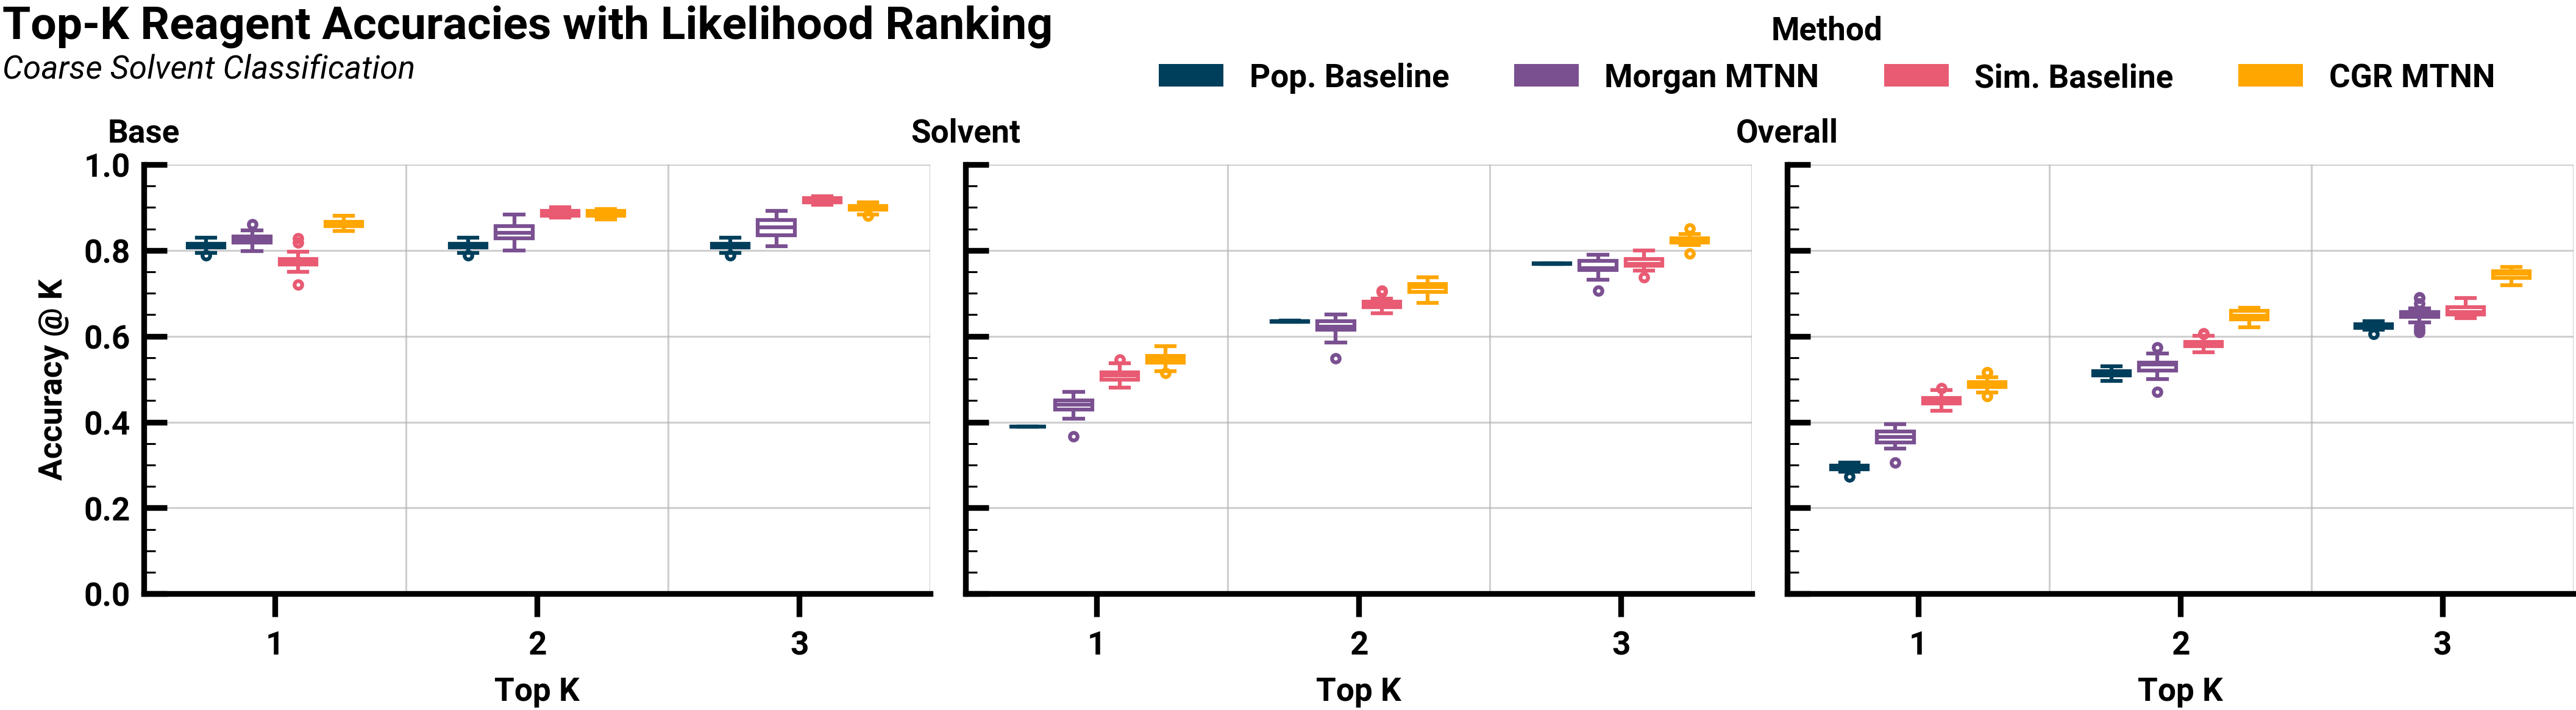

In [ ]:
vis_df = top_k_accuracies.filter(pl.col("top_k") <= 3)

fill = False
fill_legend = True
n_plots = 3
palette = extend_palette(4, SYNTHWAVE_PALETTE)

fig, axs = plot_top_k_accuracies(
    vis_df,
    hue_order=["Pop. Baseline", "Morgan MTNN", "Sim. Baseline", "CGR MTNN"],
    figsize=(3.5 * n_plots - (n_plots - 1) * 0.5, 2.69),
    palette=palette,
    despine=True,
    fill=fill,
)

add_titles(
    fig=fig,
    title="Top-K Reagent Accuracies with Likelihood Ranking",
    subtitle=f"{SOLVENT_CLASSIFICATION.title()} Solvent Classification",
)

create_fig_legend(fig, axs, n_cols=4, fill_legend=fill_legend)

fig.tight_layout()

plt.savefig(
    f"../reports/figures/{SOLVENT_CLASSIFICATION}_solvs/accuracies/top_k_accuracies_with_likelihood_ranking.svg",
    bbox_inches="tight",
)

/tmp/ipykernel_3290538/2515487574.py:21: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


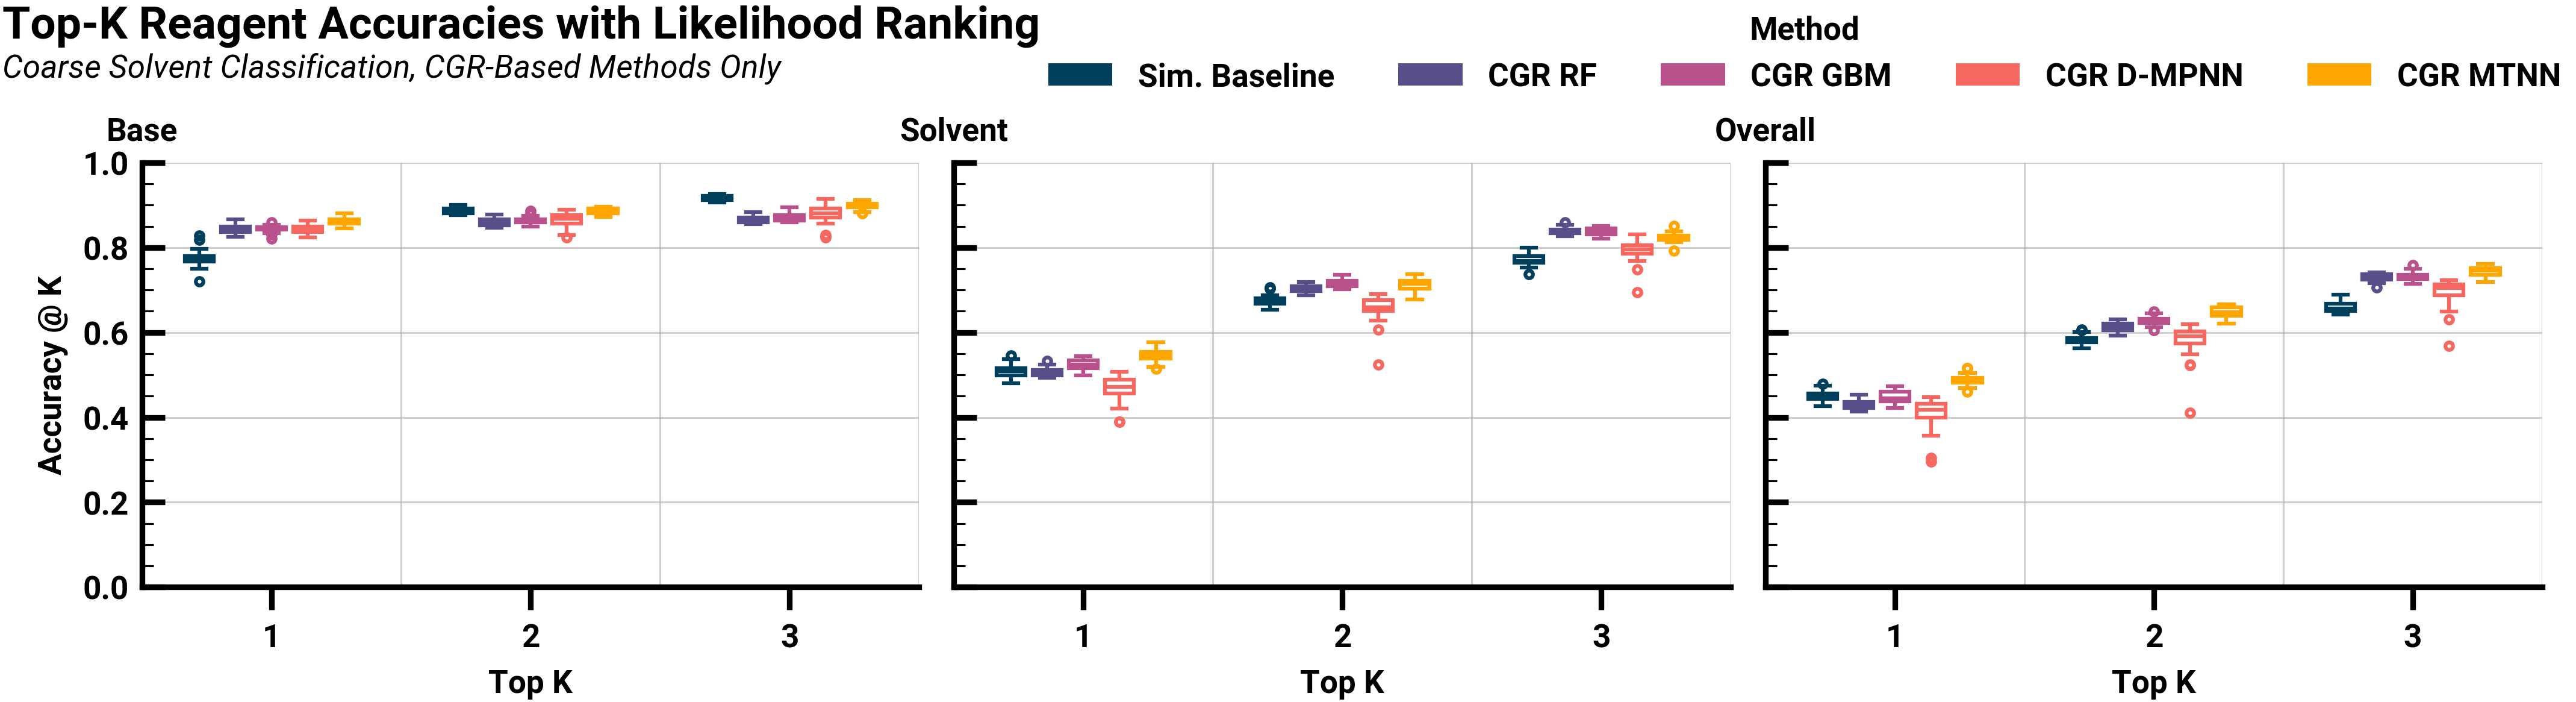

In [ ]:
cgr_only_palette = extend_palette(5, SYNTHWAVE_PALETTE)
n_plots = 3

fig, axs = plot_top_k_accuracies(
    vis_df,
    hue_order=["Sim. Baseline", "CGR RF", "CGR GBM", "CGR D-MPNN", "CGR MTNN"],
    figsize=(3.5 * n_plots - (n_plots - 1) * 0.5, 2.69),
    palette=cgr_only_palette,
    despine=True,
    fill=fill,
)

add_titles(
    fig=fig,
    title="Top-K Reagent Accuracies with Likelihood Ranking",
    subtitle=f"{SOLVENT_CLASSIFICATION.title()} Solvent Classification, CGR-Based Methods Only",
)

create_fig_legend(fig, axs, n_cols=5, fill_legend=fill_legend)

fig.tight_layout()

plt.savefig(
    f"../reports/figures/{SOLVENT_CLASSIFICATION}_solvs/accuracies/top_k_accuracies_with_likelihood_ranking_cgr_only.svg",
    bbox_inches="tight",
)

If we instead allow the predictions for the solvent and base to be independent of each other, i.e. we just take the kth highest probability for a reagent class to be the kth prediction for that reagent class:


/tmp/ipykernel_3290538/1091337551.py:26: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


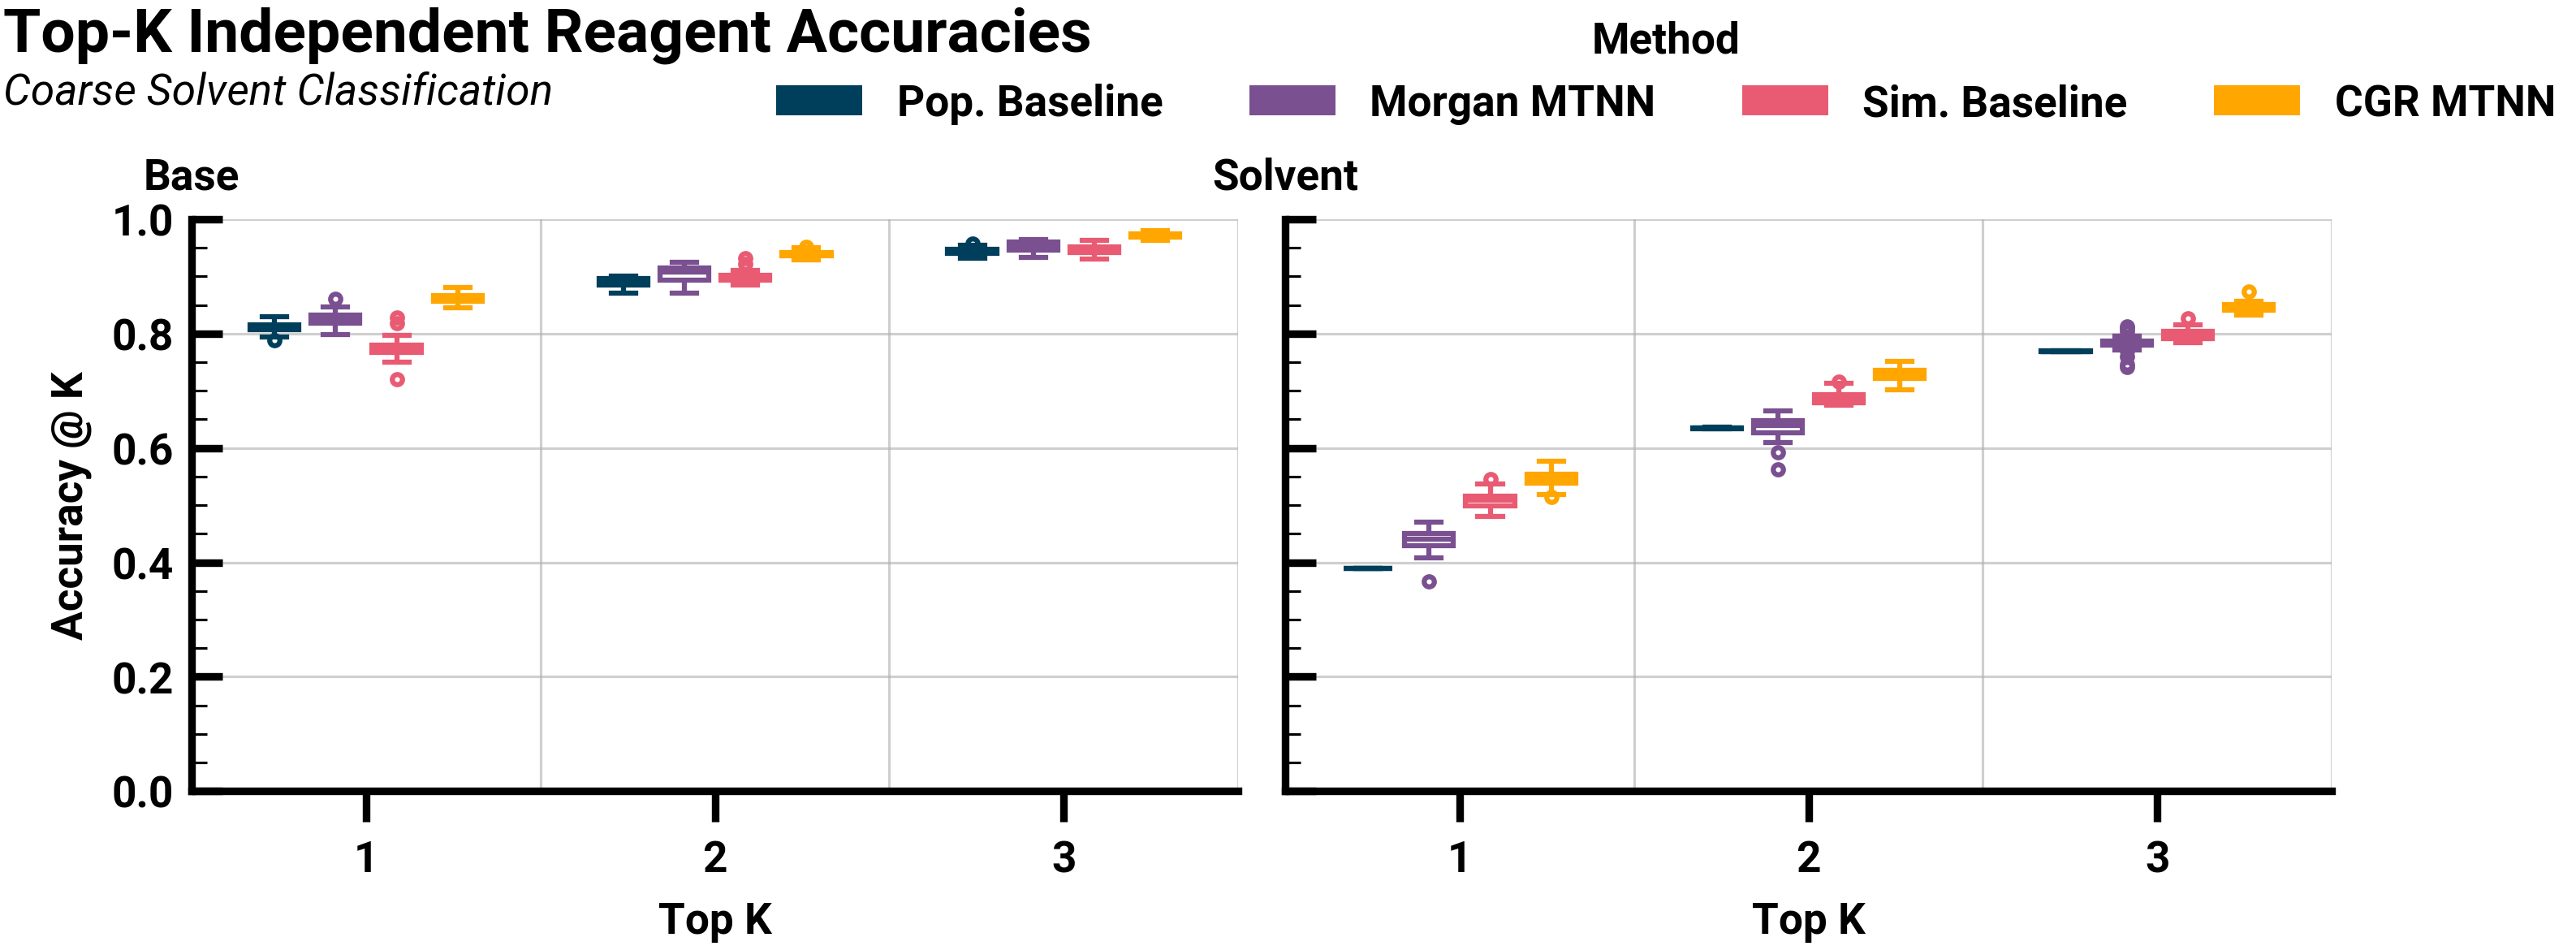

In [ ]:
independent_vis_df = independent_top_k_accuracies.filter(pl.col("top_k") <= 3)

n_plots = 2

fig, axs = plot_top_k_accuracies(
    vis_df=independent_vis_df,
    reagent_types=["Base", "Solvent"],
    hue_order=["Pop. Baseline", "Morgan MTNN", "Sim. Baseline", "CGR MTNN"],
    figsize=(3.5 * n_plots - (n_plots - 1) * 0.5, 2.69),
    palette=palette,
    share_y=True,
)

for ax in axs:
    ax.tick_params(axis="x", which="both", direction="out")
    ax.set_ylim(0, 1)

add_titles(
    fig=fig,
    title="Top-K Independent Reagent Accuracies",
    subtitle=f"{SOLVENT_CLASSIFICATION.title()} Solvent Classification",
)

create_fig_legend(fig, axs, n_cols=4, fill_legend=fill_legend)

fig.tight_layout()

plt.savefig(
    f"../reports/figures/{SOLVENT_CLASSIFICATION}_solvs/accuracies/top_k_accuracies_independent.svg",
    bbox_inches="tight",
)


/tmp/ipykernel_3290538/3048195476.py:27: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


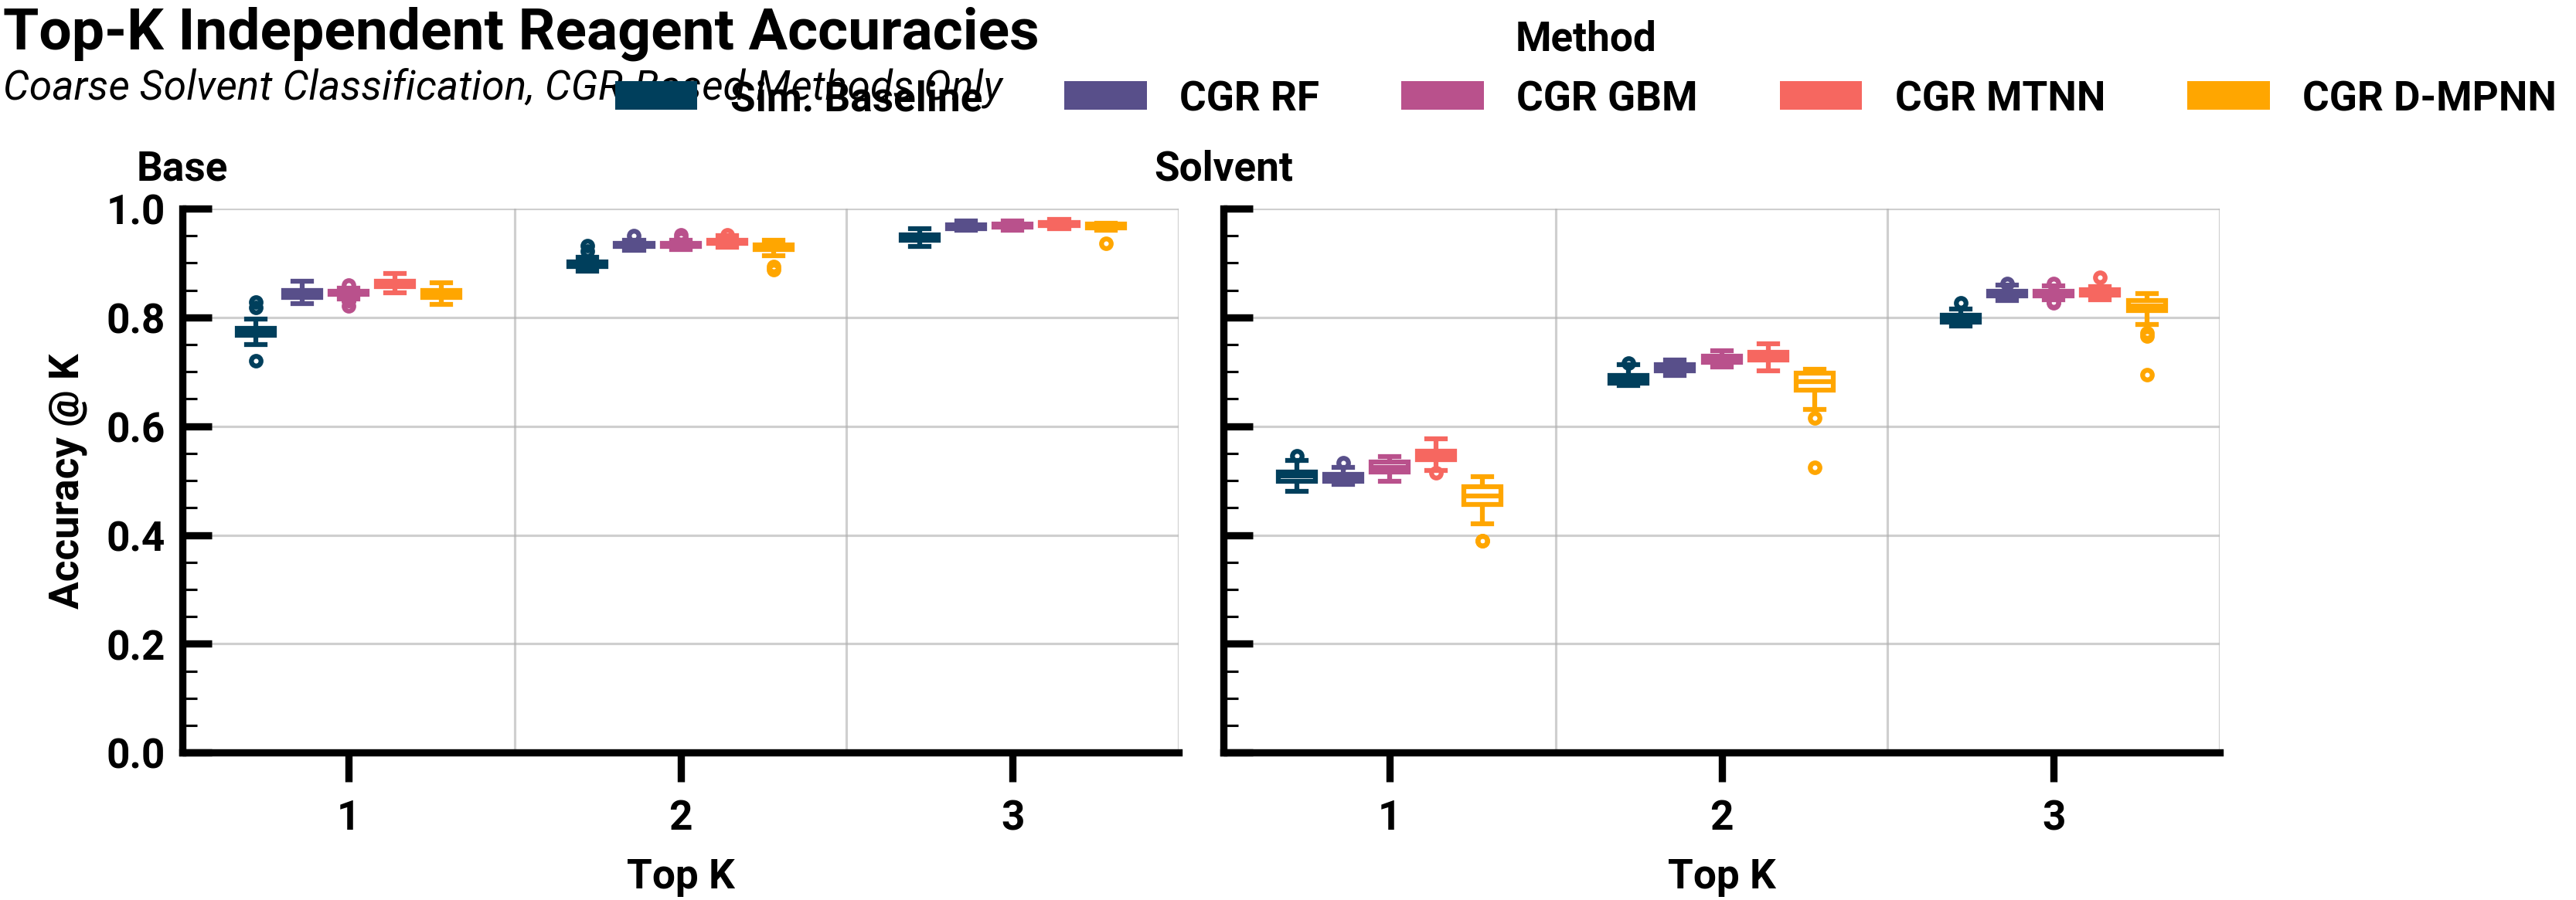

In [ ]:
fig, axs = plot_top_k_accuracies(
    vis_df=independent_vis_df,
    reagent_types=["Base", "Solvent"],
    hue_order=["Sim. Baseline", "CGR RF", "CGR GBM", "CGR MTNN", "CGR D-MPNN"],
    figsize=(3.5 * n_plots - (n_plots - 1) * 0.5, 2.69),
    despine=True,
    palette=cgr_only_palette,
)

for ax in axs:
    ax.tick_params(axis="x", which="both", direction="out")
    ax.set_ylim(0, 1)

add_titles(
    fig=fig,
    title="Top-K Independent Reagent Accuracies",
    subtitle=f"{SOLVENT_CLASSIFICATION.title()} Solvent Classification, CGR-Based Methods Only",
)

create_fig_legend(
    fig,
    axs,
    n_cols=5,
    fill_legend=fill_legend,
)

fig.tight_layout()

plt.savefig(
    f"../reports/figures/{SOLVENT_CLASSIFICATION}_solvs/accuracies/top_k_accuracies_independent_cgr_only.svg",
    bbox_inches="tight",
)

### Performing Statistical Analysis of Results

---

Of course, we need to understand whether these results are significant, therefore we can implement some of the methods for assessing this as described [here](https://chemrxiv.org/engage/api-gateway/chemrxiv/assets/orp/resource/item/672a91bd7be152b1d01a926b/original/practically-significant-method-comparison-protocols-for-machine-learning-in-small-molecule-drug-discovery.pdf) and implemented [here](https://www.blopig.com/blog/2024/12/visualising-and-validating-differences-between-machine-learning-models-on-small-benchmark-datasets/):


Before performing any statistical tests, we need to understand whether we can use parametric tests:

We first test for homogenuity of variances:


In [ ]:
metrics = ["accuracy"]
reagent_types = ["Base", "Solvent", "Overall"]
top_ks = [1, 2, 3]

n_metrics = len(metrics) * len(reagent_types) * len(top_ks)

for metric in metrics:
    for reagent_type in reagent_types:
        for top_k in top_ks:
            if reagent_type == "Overall":
                df = vis_df
            else:
                df = independent_vis_df

            groups = (
                df.filter(
                    (pl.col("reagent_type") == reagent_type)
                    & (pl.col("top_k") == top_k)
                    & (pl.col("method") != "Pop. Baseline")
                )
                .group_by("method")
                .agg(pl.col(metric))[metric]
                .to_list()
            )

            stat, pvalue = levene(*groups)

            print(
                f"{reagent_type} @ {top_k} {metric} Levene's Test: p-value = {pvalue}"
            )

Base @ 1 accuracy Levene's Test: p-value = 0.025851211245025867
Base @ 2 accuracy Levene's Test: p-value = 0.0007694618364315133
Base @ 3 accuracy Levene's Test: p-value = 0.022963137275056732
Solvent @ 1 accuracy Levene's Test: p-value = 0.00039917994504282643
Solvent @ 2 accuracy Levene's Test: p-value = 0.0004503354479138649
Solvent @ 3 accuracy Levene's Test: p-value = 0.007110432884105872
Overall @ 1 accuracy Levene's Test: p-value = 0.0005819619969484865
Overall @ 2 accuracy Levene's Test: p-value = 0.001877836074737872
Overall @ 3 accuracy Levene's Test: p-value = 0.02103962650360496


In [ ]:
for metric in metrics:
    for reagent_type in reagent_types:
        for top_k in top_ks:
            if reagent_type == "Overall":
                df = vis_df
            else:
                df = independent_vis_df

            groups = (
                # Including Pop. Baseline for variance ratio shouldn't be done, since we expect the variance to be very small.
                df.filter(
                    (pl.col("reagent_type") == reagent_type)
                    & (pl.col("top_k") == top_k)
                    & ~(pl.col("method").is_in(["Pop. Baseline"]))
                )
                .group_by("method")
                .agg(pl.var(metric))
            ).sort(metric, descending=True)

            print(
                f"{reagent_type} @ {top_k} {metric.title()} Max Variance Ratio: {groups[metric][0] / groups[metric][-1]:.3f}",
                f"{groups['method'][0]}, {groups['method'][-1]}",
            )

Base @ 1 Accuracy Max Variance Ratio: 6.454 Sim. Baseline, CGR MTNN
Base @ 2 Accuracy Max Variance Ratio: 7.281 Morgan MTNN, CGR RF
Base @ 3 Accuracy Max Variance Ratio: 4.011 Morgan MTNN, CGR MTNN
Solvent @ 1 Accuracy Max Variance Ratio: 10.644 CGR D-MPNN, CGR RF
Solvent @ 2 Accuracy Max Variance Ratio: 24.068 CGR D-MPNN, CGR RF
Solvent @ 3 Accuracy Max Variance Ratio: 18.735 CGR D-MPNN, CGR RF
Overall @ 1 Accuracy Max Variance Ratio: 13.229 CGR D-MPNN, CGR RF
Overall @ 2 Accuracy Max Variance Ratio: 18.567 CGR D-MPNN, CGR RF
Overall @ 3 Accuracy Max Variance Ratio: 12.795 CGR D-MPNN, CGR RF


Our results violate the assumption of homengenuity of variances, so we must use a non-parametric test, we test for normality anyway:


### Performing Non-Parametric Test


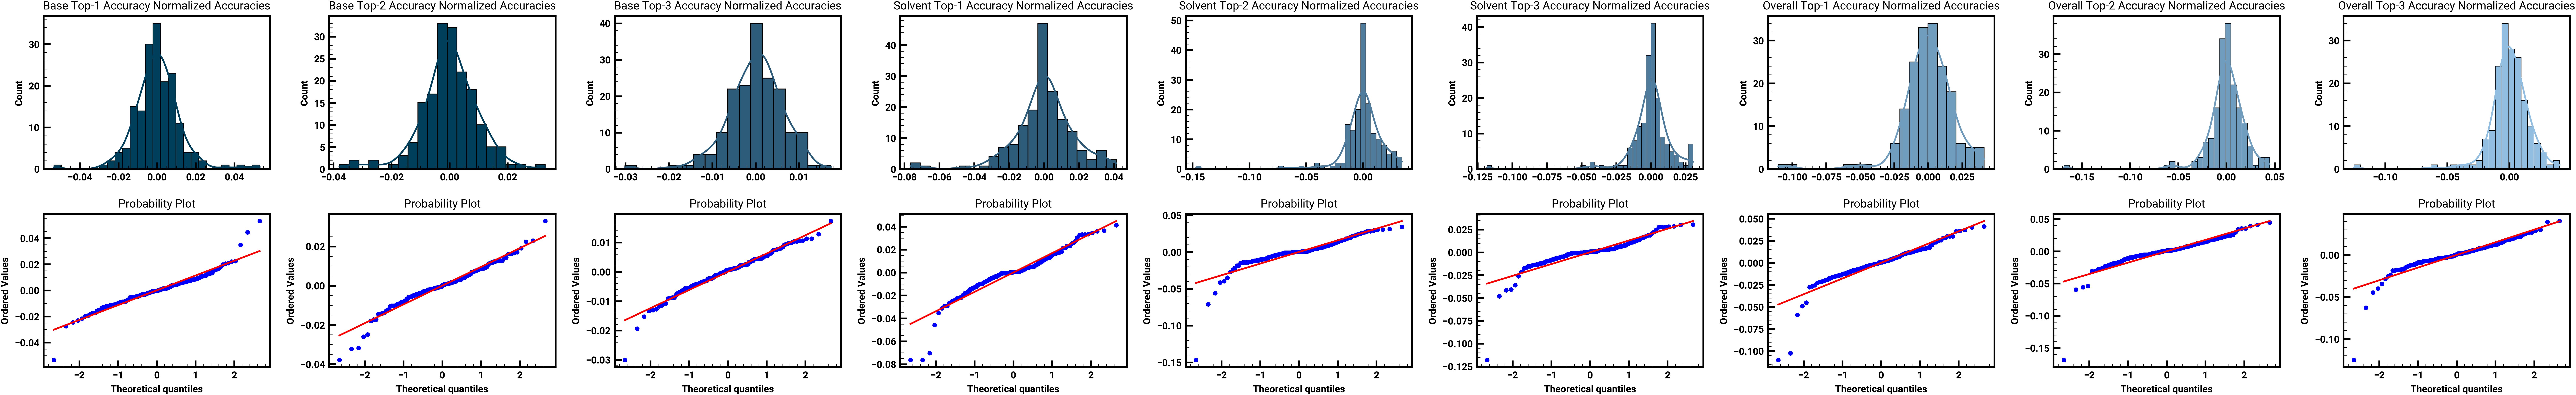

/tmp/ipykernel_3290538/4270601231.py:58: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=n_metrics, figsize=(n_metrics * 3.5, 5))

i = 0
for metric in metrics:
    for reagent_type in reagent_types:
        for top_k in top_ks:
            if reagent_type == "Overall":
                df = vis_df
            else:
                df = independent_vis_df

            mean_accs = (
                df.filter(
                    (pl.col("reagent_type") == reagent_type)
                    & (pl.col("top_k") == top_k)
                )
                .group_by("method")
                .mean()
                .select("method", "accuracy")
                .rename({"accuracy": "mean_accuracy"})
            )

            norm_accs = (
                df.filter(
                    (pl.col("reagent_type") == reagent_type)
                    & (pl.col("top_k") == top_k)
                )
                .join(mean_accs, on="method")
                .with_columns(
                    (pl.col("accuracy") - pl.col("mean_accuracy")).alias(
                        "norm_accuracy"
                    )
                )
            )

            sns.histplot(
                norm_accs["norm_accuracy"].to_numpy(),
                color=SYNTHWAVE_SINGLE_HUE_PALETTE[i // 2],
                kde=True,
                ax=axs[0, i],
                alpha=1,
            )

            probplot(
                norm_accs["norm_accuracy"].to_numpy(),
                dist="norm",
                plot=axs[1, i],
            )

            axs[0, i].set_title(
                f"{reagent_type.title()} Top-{top_k} {metric.title()} Normalized Accuracies"
            )

            i += 1

plt.show()

fig.tight_layout()

In [ ]:
# We start by first determining the p-values using the Friedman test
import pingouin as pg

for metric in metrics:
    for reagent_type in reagent_types:
        for top_k in top_ks:
            if reagent_type == "Overall":
                df = vis_df
            else:
                df = independent_vis_df

            stat_df = df.filter(
                (pl.col("reagent_type") == reagent_type)
                & (pl.col("top_k") == top_k)
            )

            stat_df = stat_df.with_columns(
                [
                    pl.Series(
                        "split_fold",
                        [
                            f"{split}_{fold}"
                            for split, fold in zip(
                                stat_df["split"].to_numpy(),
                                stat_df["fold"].to_numpy(),
                            )
                        ],
                    )
                ]
            )

            p_value = pg.friedman(
                stat_df.to_pandas(),
                dv=metric,
                within="method",
                subject="split_fold",
            )

            print(
                f"{reagent_type} {metric.title()} @ {top_k} Friedman Test Value: {p_value['p-unc'].values[0]}"
            )

Base Accuracy @ 1 Friedman Test Value: 5.111647098151935e-26
Base Accuracy @ 2 Friedman Test Value: 2.5574017881396065e-23
Base Accuracy @ 3 Friedman Test Value: 2.8508369311913273e-22
Solvent Accuracy @ 1 Friedman Test Value: 3.0003837832799753e-27
Solvent Accuracy @ 2 Friedman Test Value: 2.0347117920658164e-26
Solvent Accuracy @ 3 Friedman Test Value: 5.656110373122303e-25
Overall Accuracy @ 1 Friedman Test Value: 2.550375638105365e-27
Overall Accuracy @ 2 Friedman Test Value: 2.5190575727812775e-27
Overall Accuracy @ 3 Friedman Test Value: 1.9290655014644485e-26


Ok, so the differences are significant, let's see where they are:


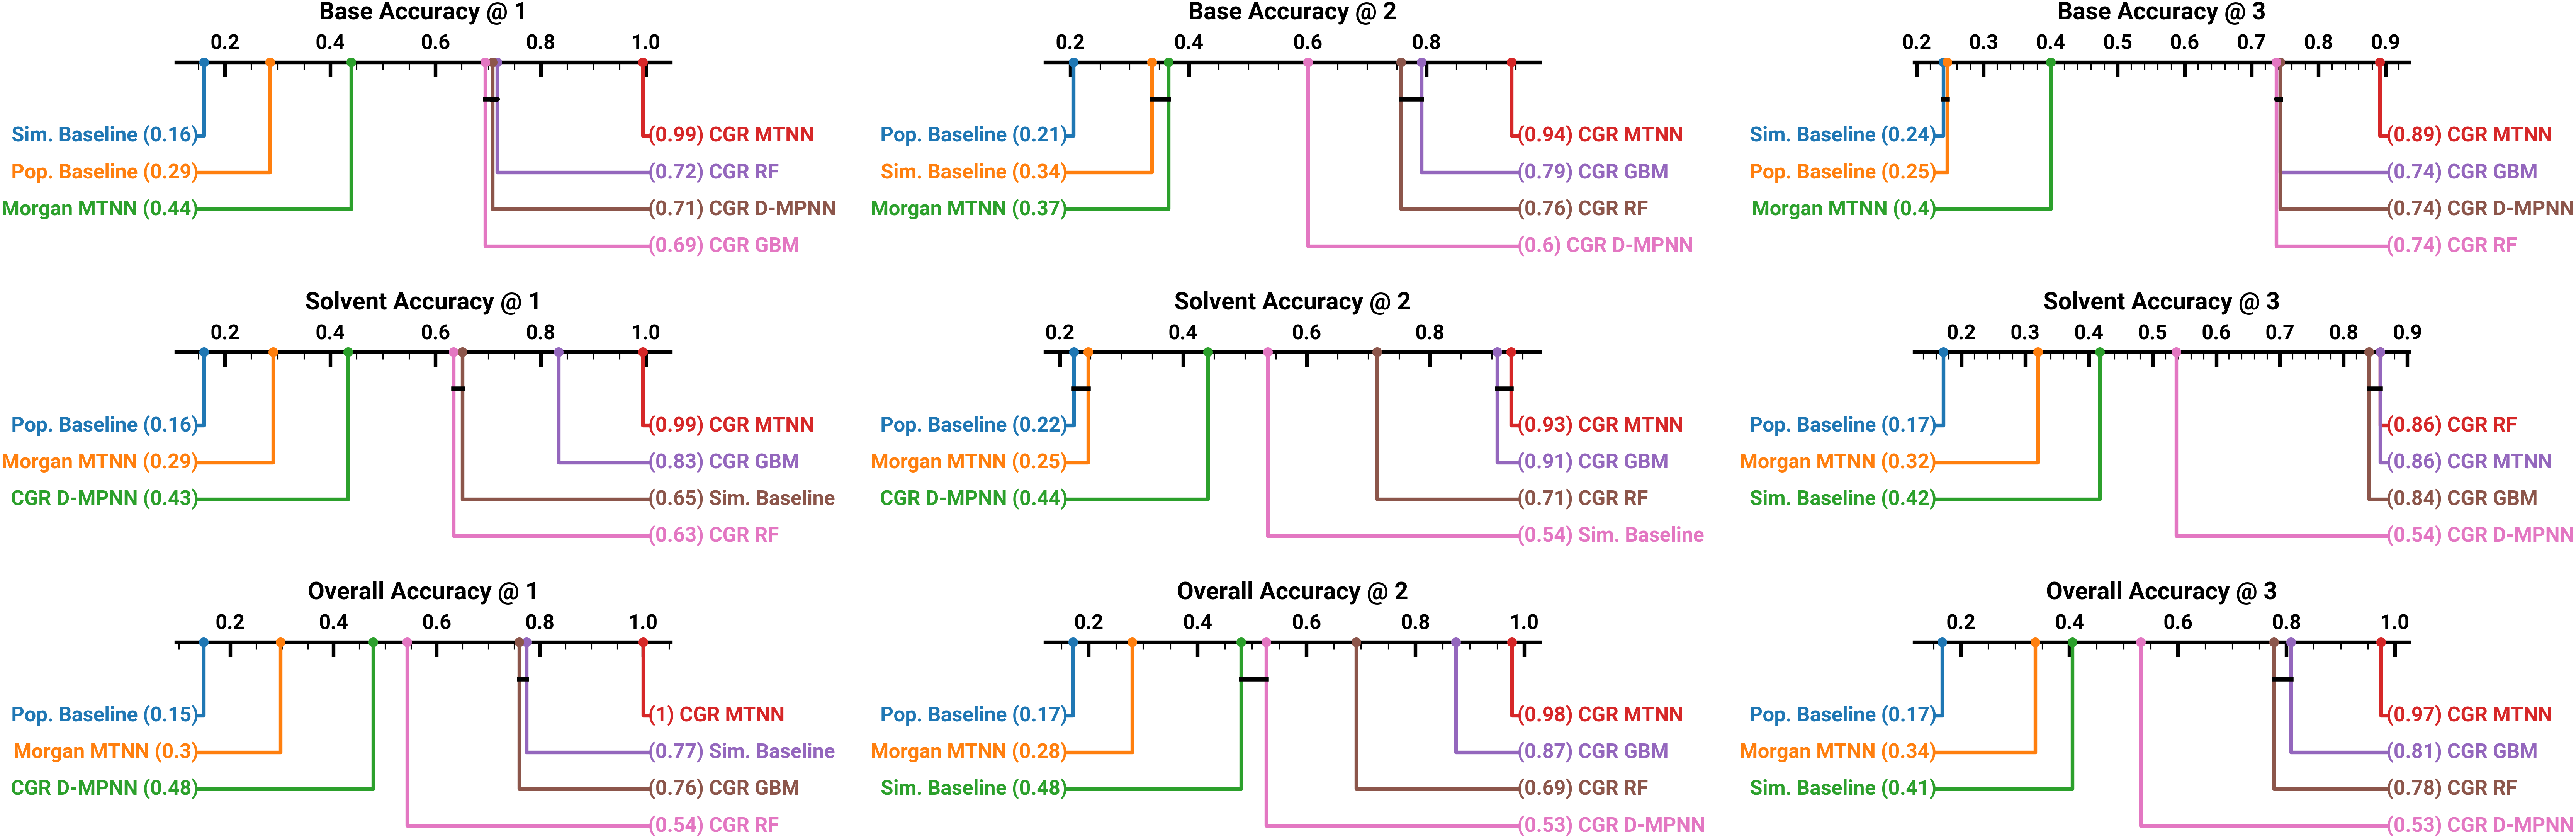

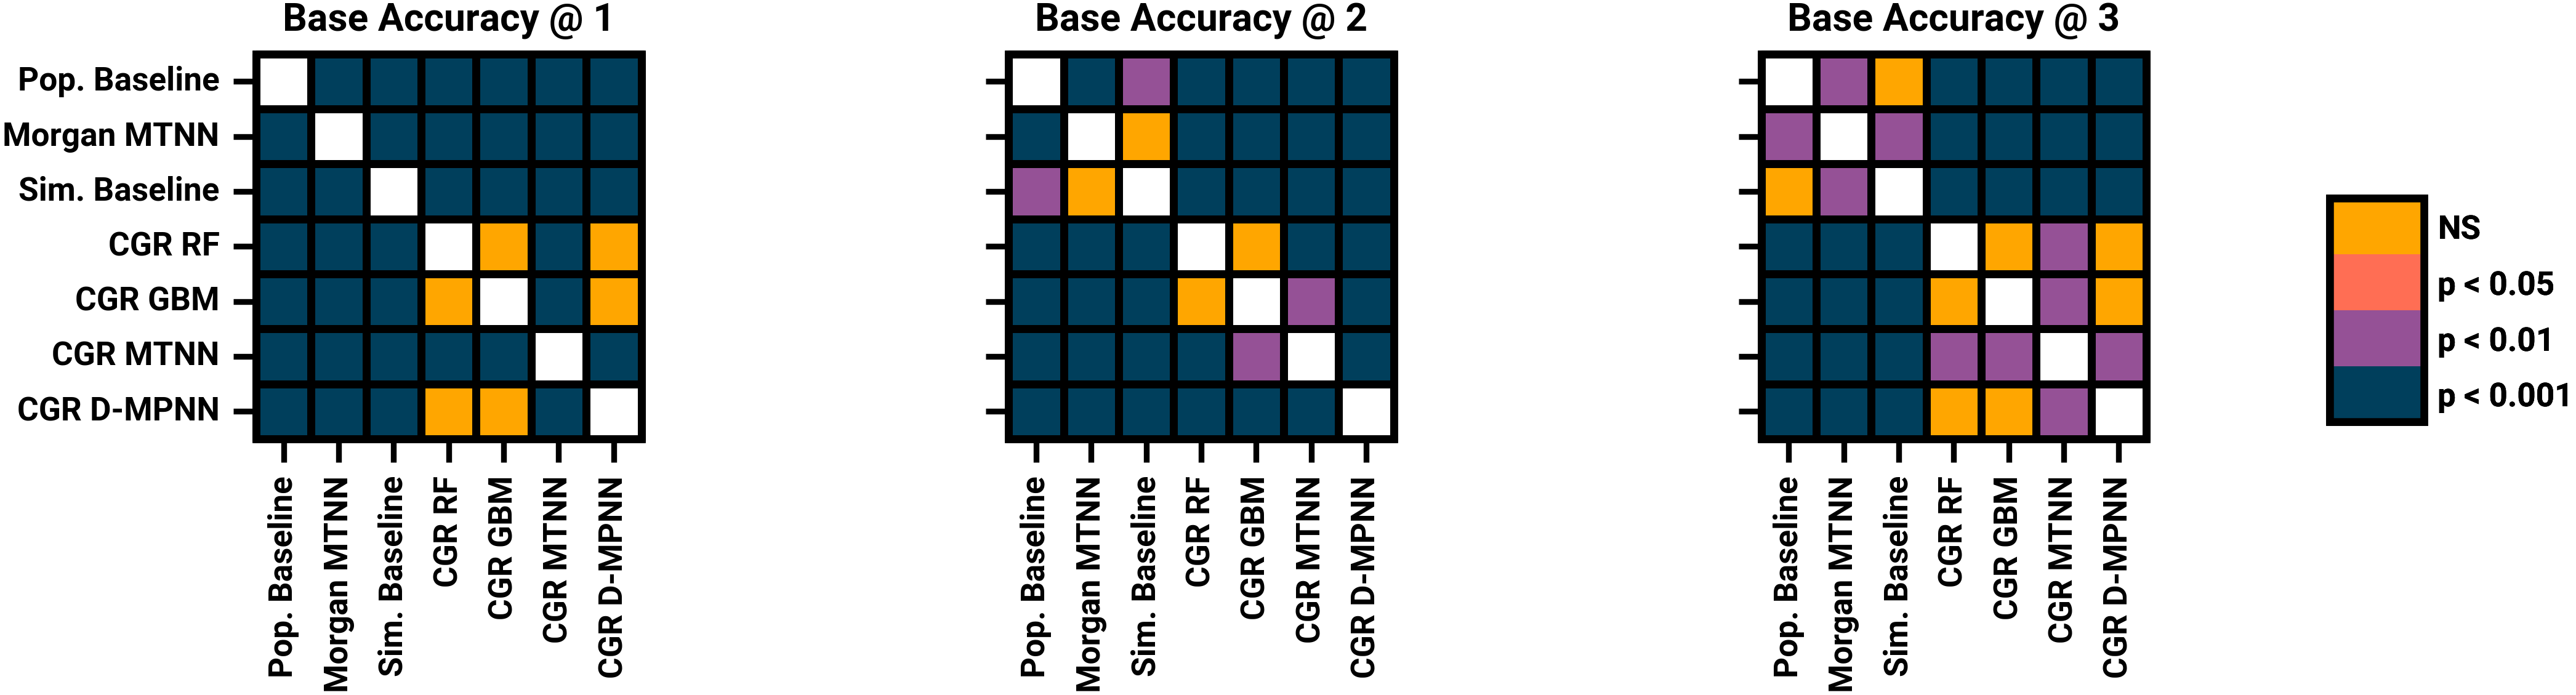

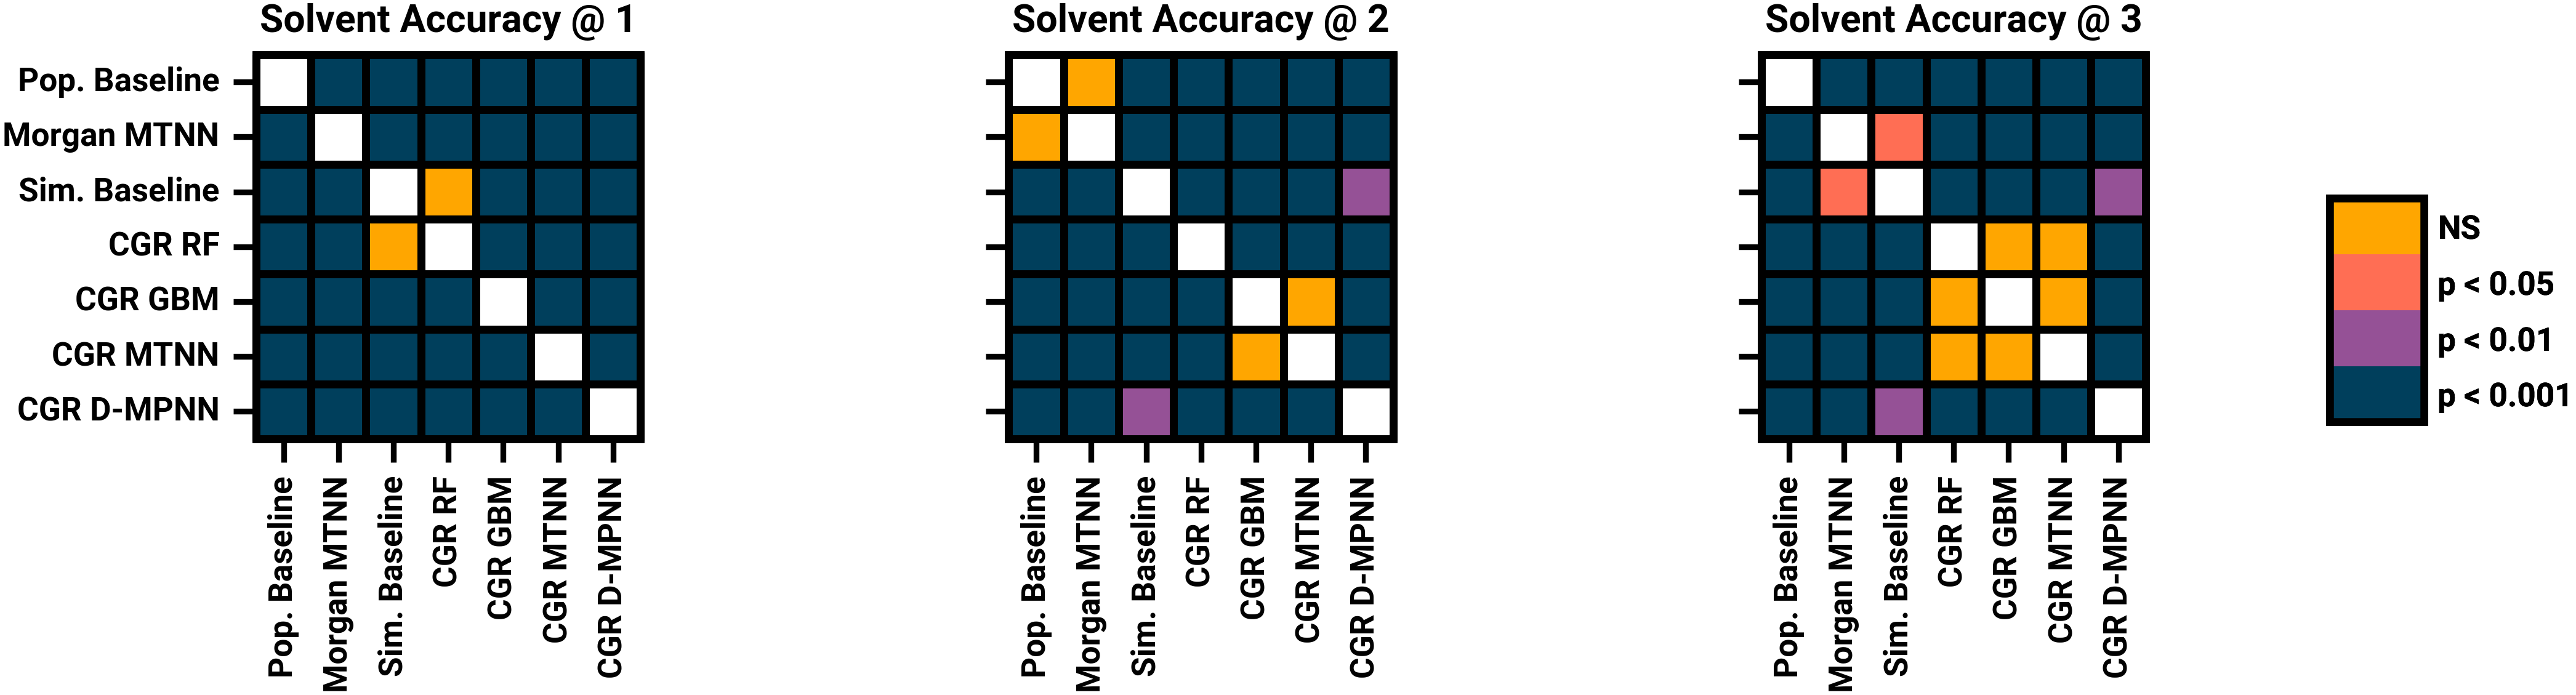

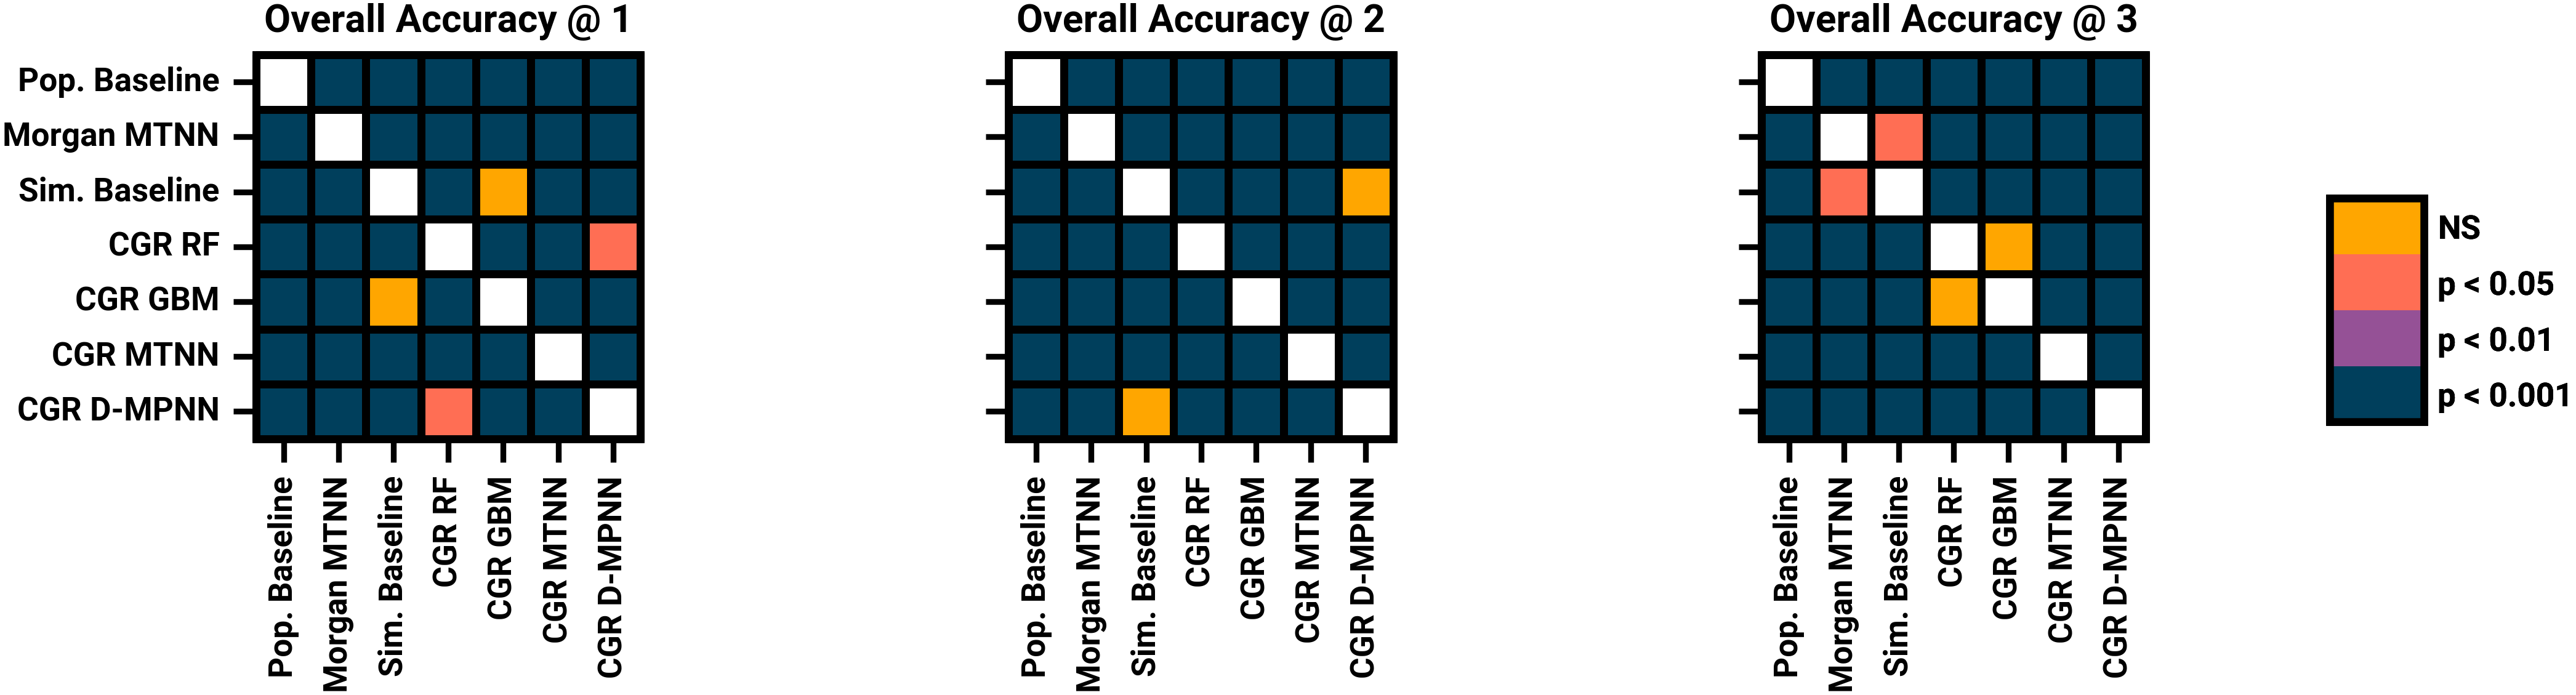

In [ ]:
os.makedirs(
    f"../reports/figures/{SOLVENT_CLASSIFICATION}_solvs/stat_analysis/accuracies",
    exist_ok=True,
)

fig, axs = plt.subplots(
    nrows=len(reagent_types),
    ncols=len(top_ks),
    figsize=(len(reagent_types) * 5, len(metrics) * 5),
)

custom_palette = (
    ["1"]
    + [SYNTHWAVE_PALETTE[-1]]
    + [SYNTHWAVE_PALETTE[i] for i in range(0, 5, 2)]
)

for metric in metrics:
    for i, reagent_type in enumerate(reagent_types):
        fig2, axs2 = plt.subplots(
            nrows=1,
            ncols=len(top_ks),
            figsize=(8.5, 2.69),
            sharey=True,
        )
        for top_k in top_ks:
            if reagent_type == "Overall":
                df = vis_df
            else:
                df = independent_vis_df

            metric_name = f"{reagent_type} {metric} @ {top_k}"

            temp_df = df.filter(
                (pl.col("reagent_type") == reagent_type)
                & (pl.col("top_k") == top_k)
            ).to_pandas()

            temp_df["cv"] = [
                (int(row["split"]) - 1) * 5 + int(row["fold"])
                for _, row in temp_df.iterrows()
            ]

            pivot_temp_df = temp_df.pivot(
                index="cv", columns="method", values="accuracy"
            )

            pivot_temp_df = pivot_temp_df[
                [
                    "Pop. Baseline",
                    "Morgan MTNN",
                    "Sim. Baseline",
                    "CGR RF",
                    "CGR GBM",
                    "CGR MTNN",
                    "CGR D-MPNN",
                ]
            ]

            pc = sp.posthoc_conover_friedman(
                pivot_temp_df,
                p_adjust="holm",
            )

            av_rank = (
                temp_df.groupby("cv")
                .accuracy.rank(pct=True)
                .groupby(temp_df.method)
                .mean()
            )

            for j, axs_ in enumerate([axs, axs2]):
                if j == 0:
                    idx = i, top_k - 1
                else:
                    idx = top_k - 1
                axs_[idx].set_title(
                    metric_name.title(),
                    fontdict={"weight": "bold"},
                )

            sp_ax, sp_cb = sp.sign_plot(
                pc,
                ax=axs2[top_k - 1],
                cmap=custom_palette,
                **{
                    "linewidths": 2,
                    "linecolor": "black",
                    "clip_on": False,
                    "square": True,
                    "cbar_ax_bbox": [1, 0.4, 0.04, 0.3],
                },
            )

            sp.critical_difference_diagram(
                ranks=av_rank, sig_matrix=pc, ax=axs[i, top_k - 1]
            )
            for spine in sp_ax.spines.values():
                spine.set_visible(True)
                spine.set_linewidth(2)

            sp_cb.outline.set_color("black")
            sp_cb.outline.set_linewidth(2)

            sp_ax.tick_params(axis="both", which="both", direction="out")
            sp_ax.tick_params(axis="both", which="minor", length=0)

        fig2.savefig(
            f"../reports/figures/{SOLVENT_CLASSIFICATION}_solvs/stat_analysis/accuracies/{reagent_type.lower()}_top_k_{metric}_posthoc.svg",
            bbox_inches="tight",
        )

fig.savefig(
    f"../reports/figures/{SOLVENT_CLASSIFICATION}_solvs/stat_analysis/accuracies/critical_difference_diagrams.svg",
    bbox_inches="tight",
)

## Analysis of alternative classification metrics

---

Whilst accuracy is a useful indicator of a classifiers performance, the presence of imbalanced classes can inflate accuracy scores. Let's look at some other common classification metrics.


### Visualing Metric Values

---

Comparing the distribution of metrics across CV runs:


In [ ]:
combined_metrics_df = process_metrics_df(independent_metrics)
combined_metrics_df = combined_metrics_df.with_columns(
    pl.col("reagent_type").replace(
        {
            f"{SOLVENT_CLASSIFICATION}_solvent": "Solvent",
            "base": "Base",
            "overall": "Overall",
        }
    )
)


/tmp/ipykernel_3290538/1475171649.py:23: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


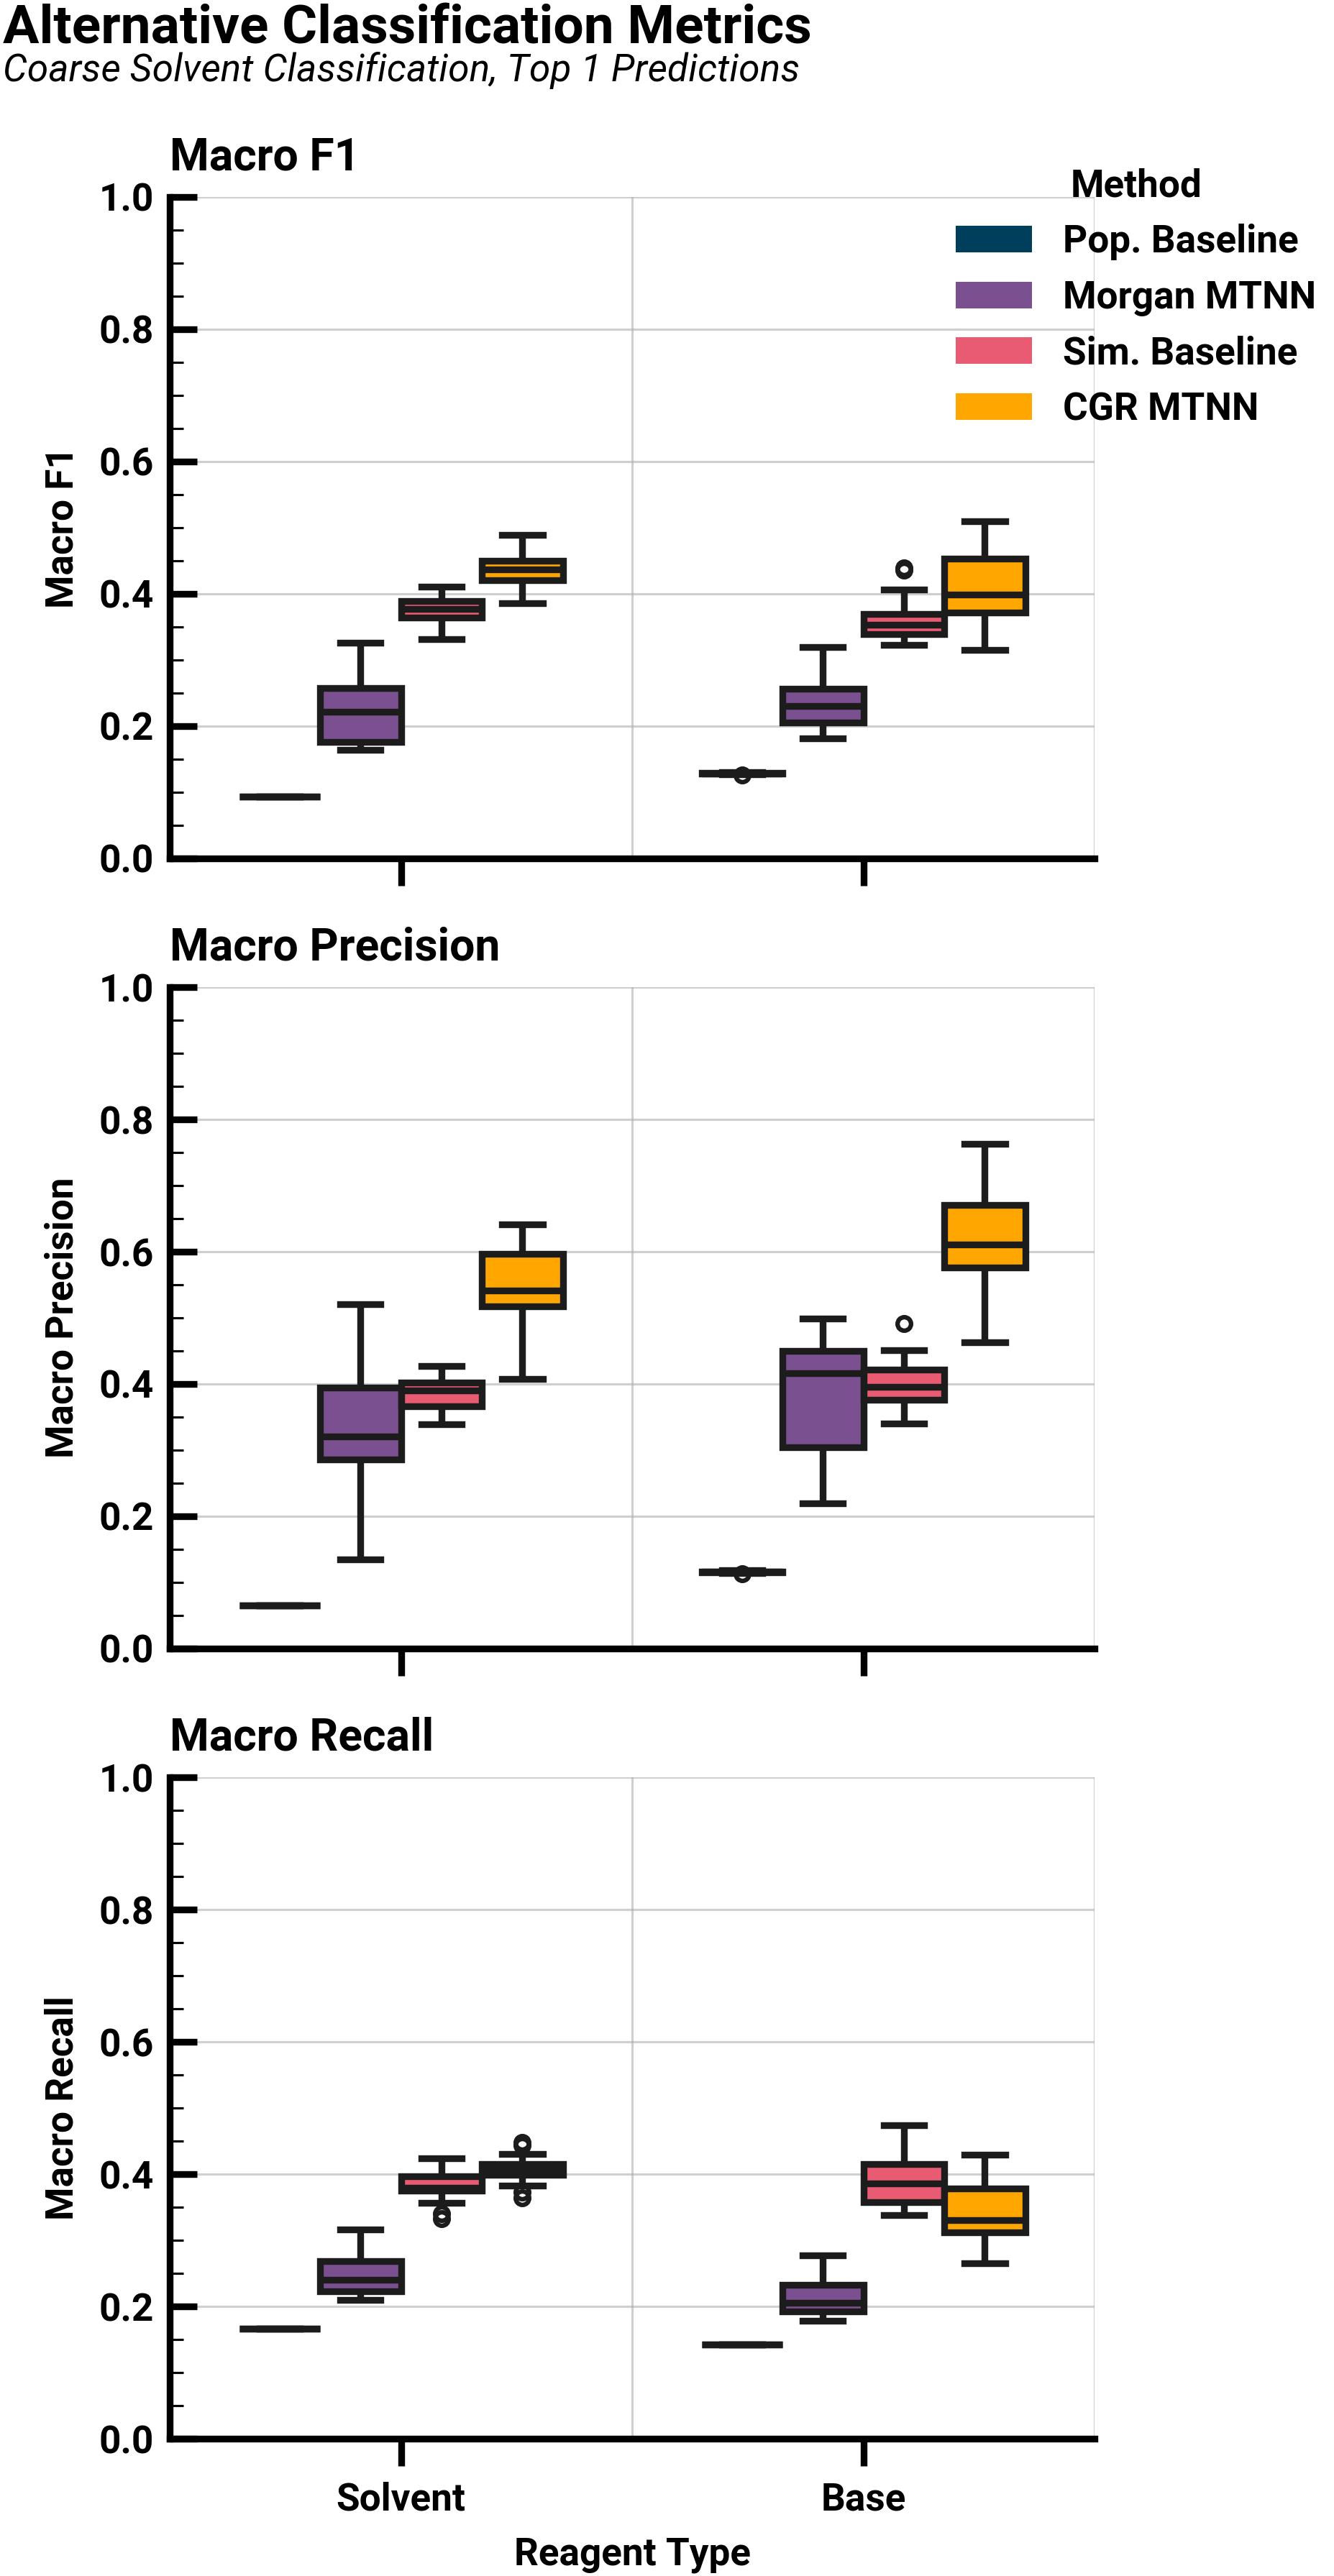

In [ ]:
fig, axs = plot_alternative_classification_metrics(
    metrics=["macro_f1", "macro_precision", "macro_recall"],
    df=combined_metrics_df,
    hue_order=["Pop. Baseline", "Morgan MTNN", "Sim. Baseline", "CGR MTNN"],
    palette=palette,
)

add_titles(
    fig=fig,
    title="Alternative Classification Metrics",
    subtitle=f"{SOLVENT_CLASSIFICATION.title()} Solvent Classification, Top 1 Predictions",
    subtitle_y=0.97,
)

create_fig_legend(
    fig,
    axs,
    n_cols=1,
    fill_legend=True,
    bbox_to_anchor=(1, 0.95),
)

fig.tight_layout()

plt.savefig(
    f"../reports/figures/{SOLVENT_CLASSIFICATION}_solvs/metrics/alternative_classification_metrics.svg",
    bbox_inches="tight",
)

/tmp/ipykernel_3290538/2424441847.py:23: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


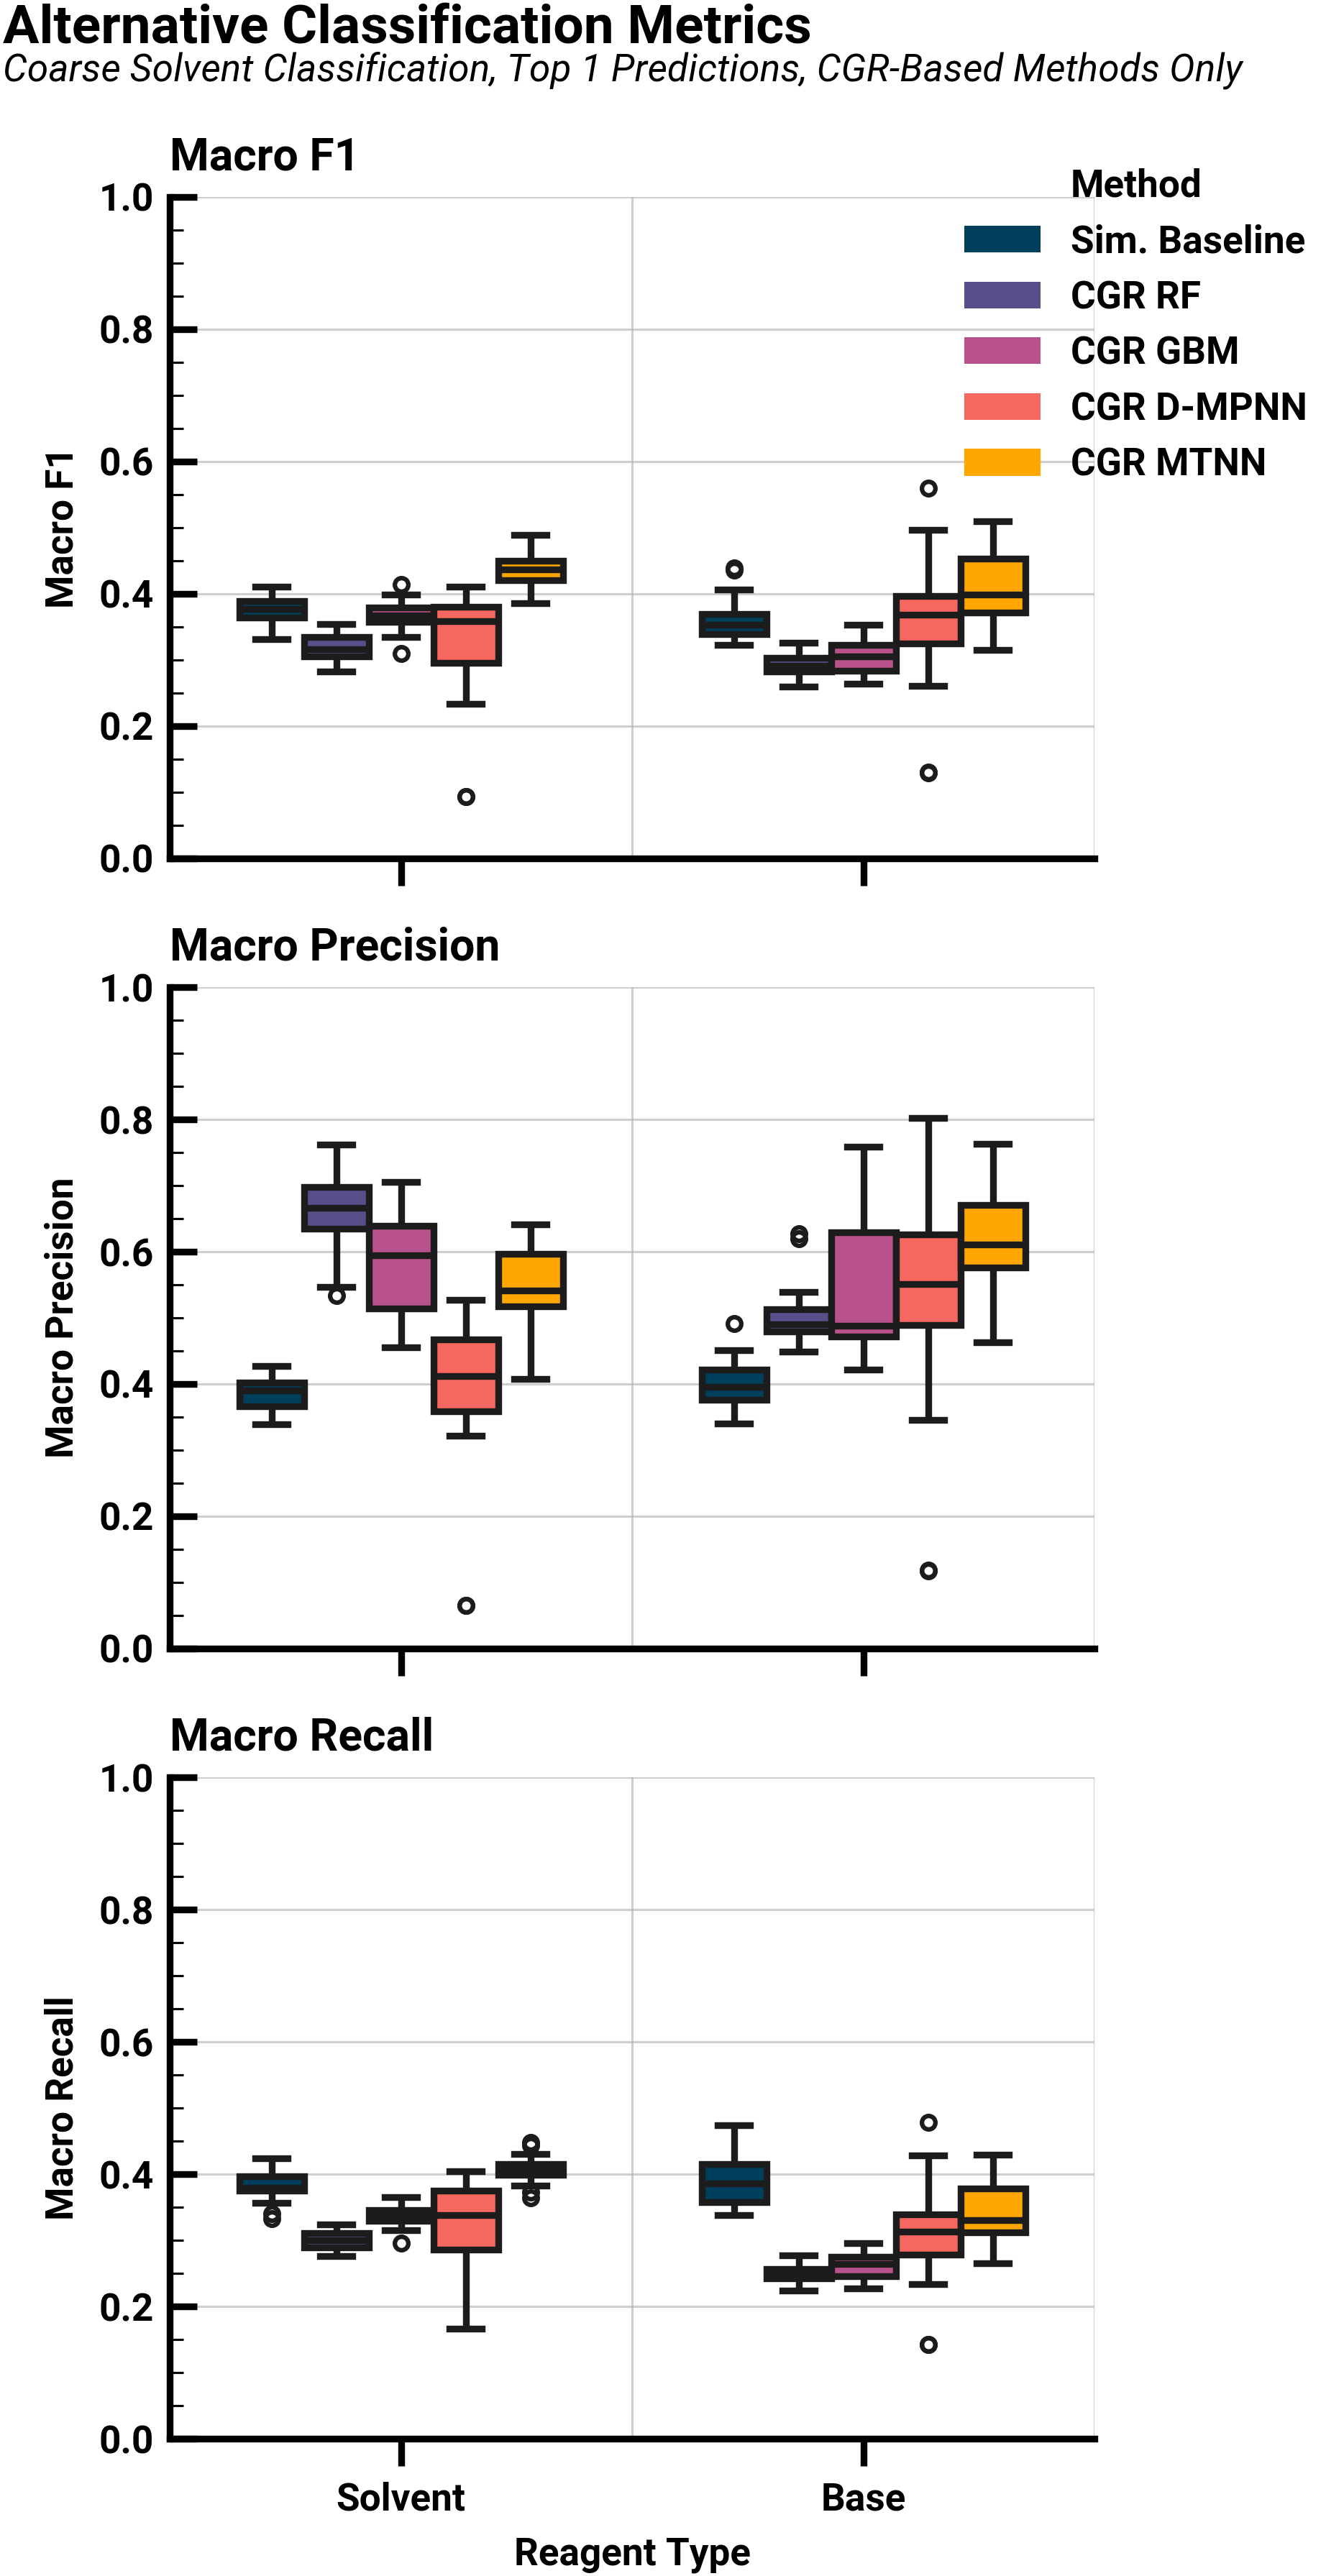

In [ ]:
fig, axs = plot_alternative_classification_metrics(
    metrics=["macro_f1", "macro_precision", "macro_recall"],
    df=combined_metrics_df,
    hue_order=["Sim. Baseline", "CGR RF", "CGR GBM", "CGR D-MPNN", "CGR MTNN"],
    palette=cgr_only_palette,
)

create_fig_legend(
    fig,
    axs,
    n_cols=1,
    fill_legend=True,
    bbox_to_anchor=(1, 0.95),
)

add_titles(
    fig=fig,
    title="Alternative Classification Metrics",
    subtitle=f"{SOLVENT_CLASSIFICATION.title()} Solvent Classification, Top 1 Predictions, CGR-Based Methods Only",
    subtitle_y=0.97,
)

fig.tight_layout()

plt.savefig(
    f"../reports/figures/{SOLVENT_CLASSIFICATION}_solvs/metrics/alternative_classification_metrics_cgr_only.svg",
    bbox_inches="tight",
)

### Statistical Testing

---

We can perform the same tests as above on these metrics instead.

Again, we check for normality:


In [ ]:
metrics = ["macro_f1", "macro_precision", "macro_recall"]
reagent_types = ["Base", "Solvent"]

for metric in metrics:
    for reagent_type in reagent_types:
        df = combined_metrics_df.filter(
            (pl.col("reagent_type") == reagent_type)
            & (pl.col("metric") == metric)
            & (pl.col("method") != "Pop. Baseline")
        )

        groups = df.group_by("method").agg(pl.col("value"))["value"].to_list()

        stat, pvalue = levene(*groups)

        print(f"{reagent_type} {metric} Levene's Test: p-value = {pvalue}")

        sorted_vars_by_method = (
            df.group_by("method")
            .agg(pl.var("value"))
            .sort("value", descending=True)
        )

        print(
            f"{reagent_type} {metric.title()} Max Variance Ratio: {sorted_vars_by_method['value'][0] / sorted_vars_by_method['value'][-1]:.3f}"
        )

Base macro_f1 Levene's Test: p-value = 4.5695516099916224e-07
Base Macro_F1 Max Variance Ratio: 35.158
Solvent macro_f1 Levene's Test: p-value = 6.748835068041394e-07
Solvent Macro_F1 Max Variance Ratio: 17.542
Base macro_precision Levene's Test: p-value = 0.00012585588703712848
Base Macro_Precision Max Variance Ratio: 21.710
Solvent macro_precision Levene's Test: p-value = 0.0004664715023054563
Solvent Macro_Precision Max Variance Ratio: 24.253
Base macro_recall Levene's Test: p-value = 2.762310485371945e-06
Base Macro_Recall Max Variance Ratio: 30.616
Solvent macro_recall Levene's Test: p-value = 8.42368868887084e-09
Solvent Macro_Recall Max Variance Ratio: 21.620


Again, we need to use non-parametric tests:


In [ ]:
for metric in metrics:
    for reagent_type in reagent_types:
        df = combined_metrics_df.filter(
            (pl.col("reagent_type") == reagent_type)
            & (pl.col("metric") == metric)
        )

        stat_df = df.with_columns(
            [
                pl.Series(
                    "split_fold",
                    [
                        f"{split}_{fold}"
                        for split, fold in zip(
                            df["split"].to_numpy(),
                            df["fold"].to_numpy(),
                        )
                    ],
                )
            ]
        )

        p_value = pg.friedman(
            stat_df.to_pandas(),
            dv="value",
            within="method",
            subject="split_fold",
        )["p-unc"].values[0]

        print(
            f"{reagent_type} {metric.title()} Friedman Test Value: {p_value}"
        )

Base Macro_F1 Friedman Test Value: 4.7467737243038603e-23
Solvent Macro_F1 Friedman Test Value: 5.899831878309329e-26
Base Macro_Precision Friedman Test Value: 4.512830270238873e-22
Solvent Macro_Precision Friedman Test Value: 2.286031203492905e-26
Base Macro_Recall Friedman Test Value: 2.4038570884571347e-25
Solvent Macro_Recall Friedman Test Value: 9.230291463892194e-27


And again, all of the metrics contain some significant difference, let's work out where:


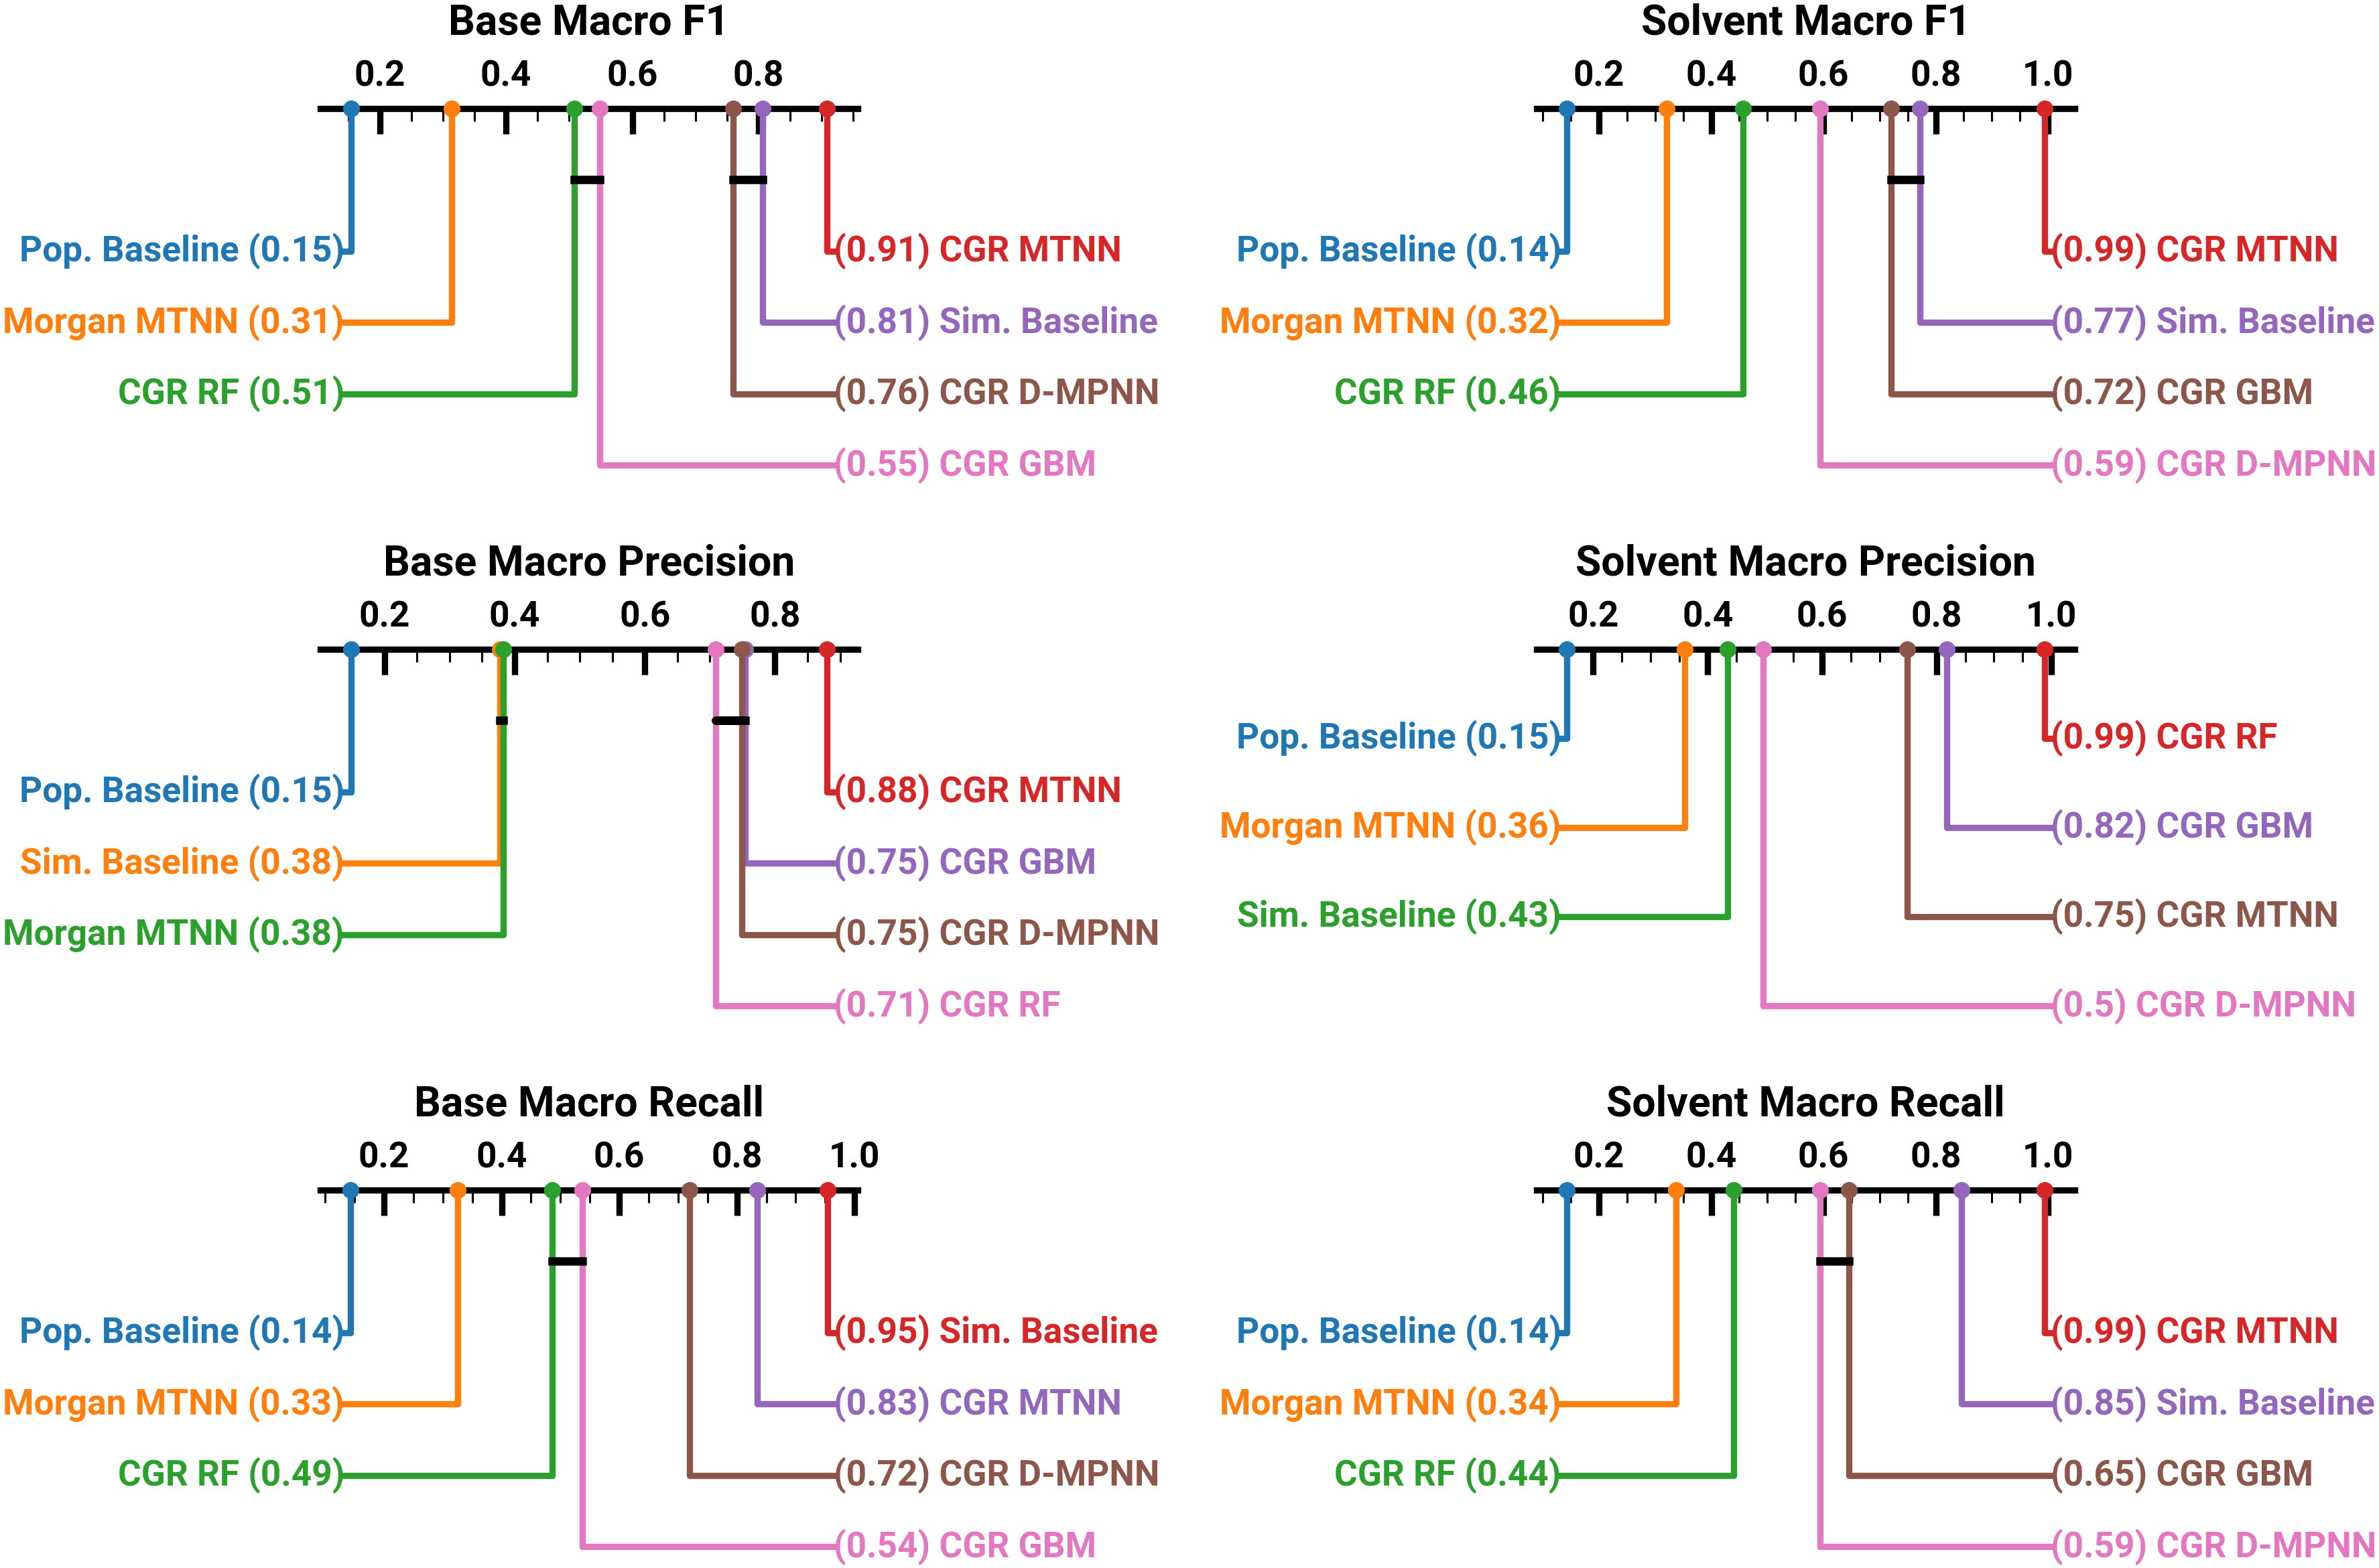

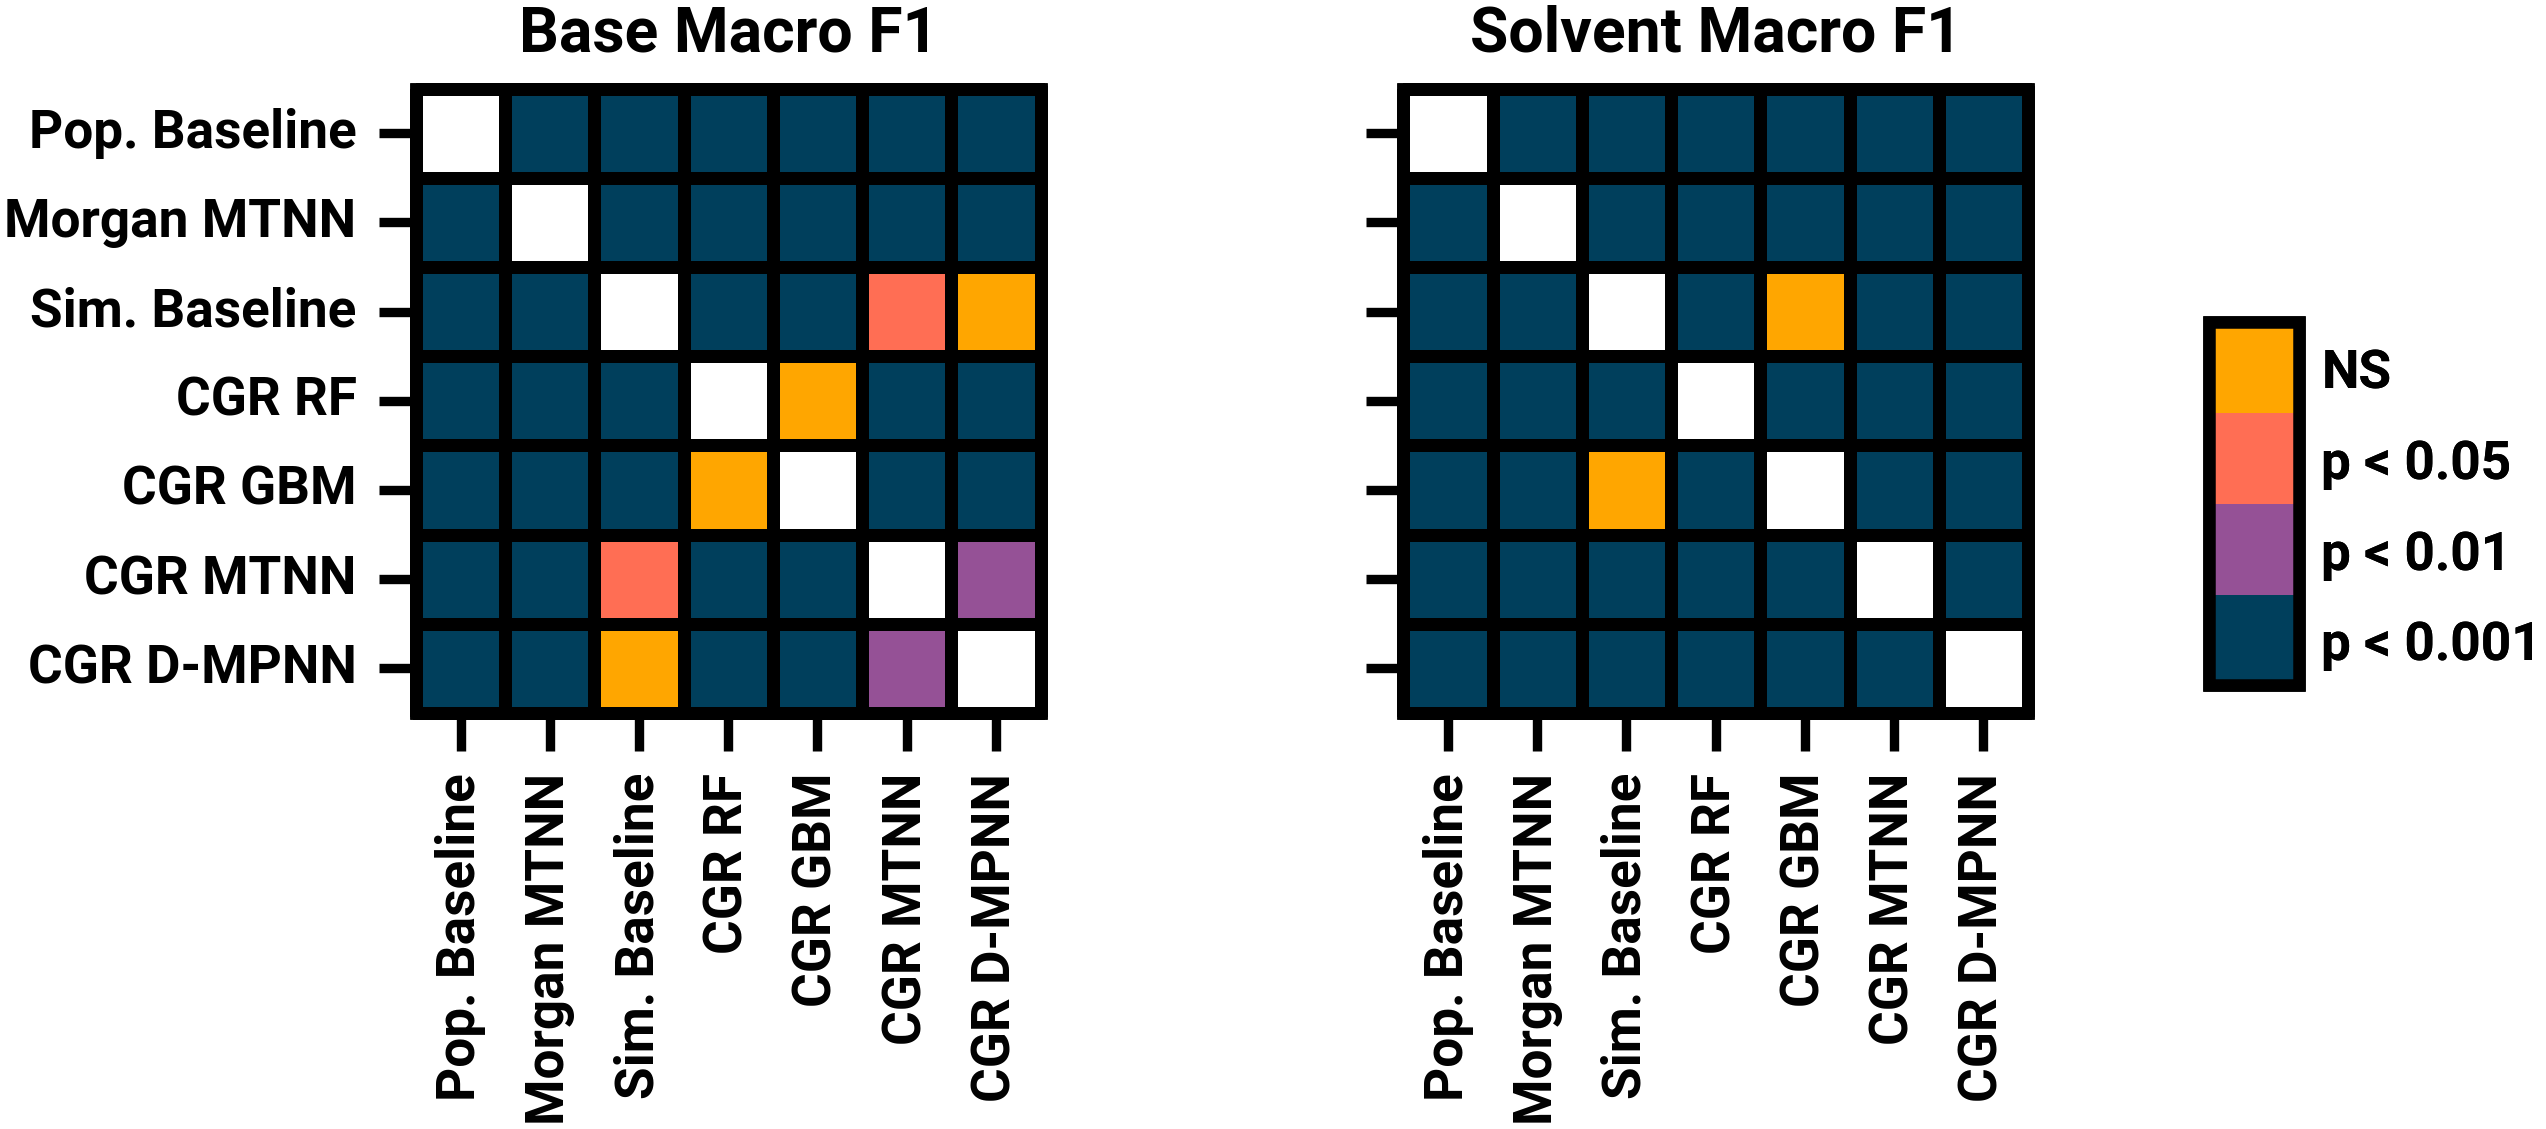

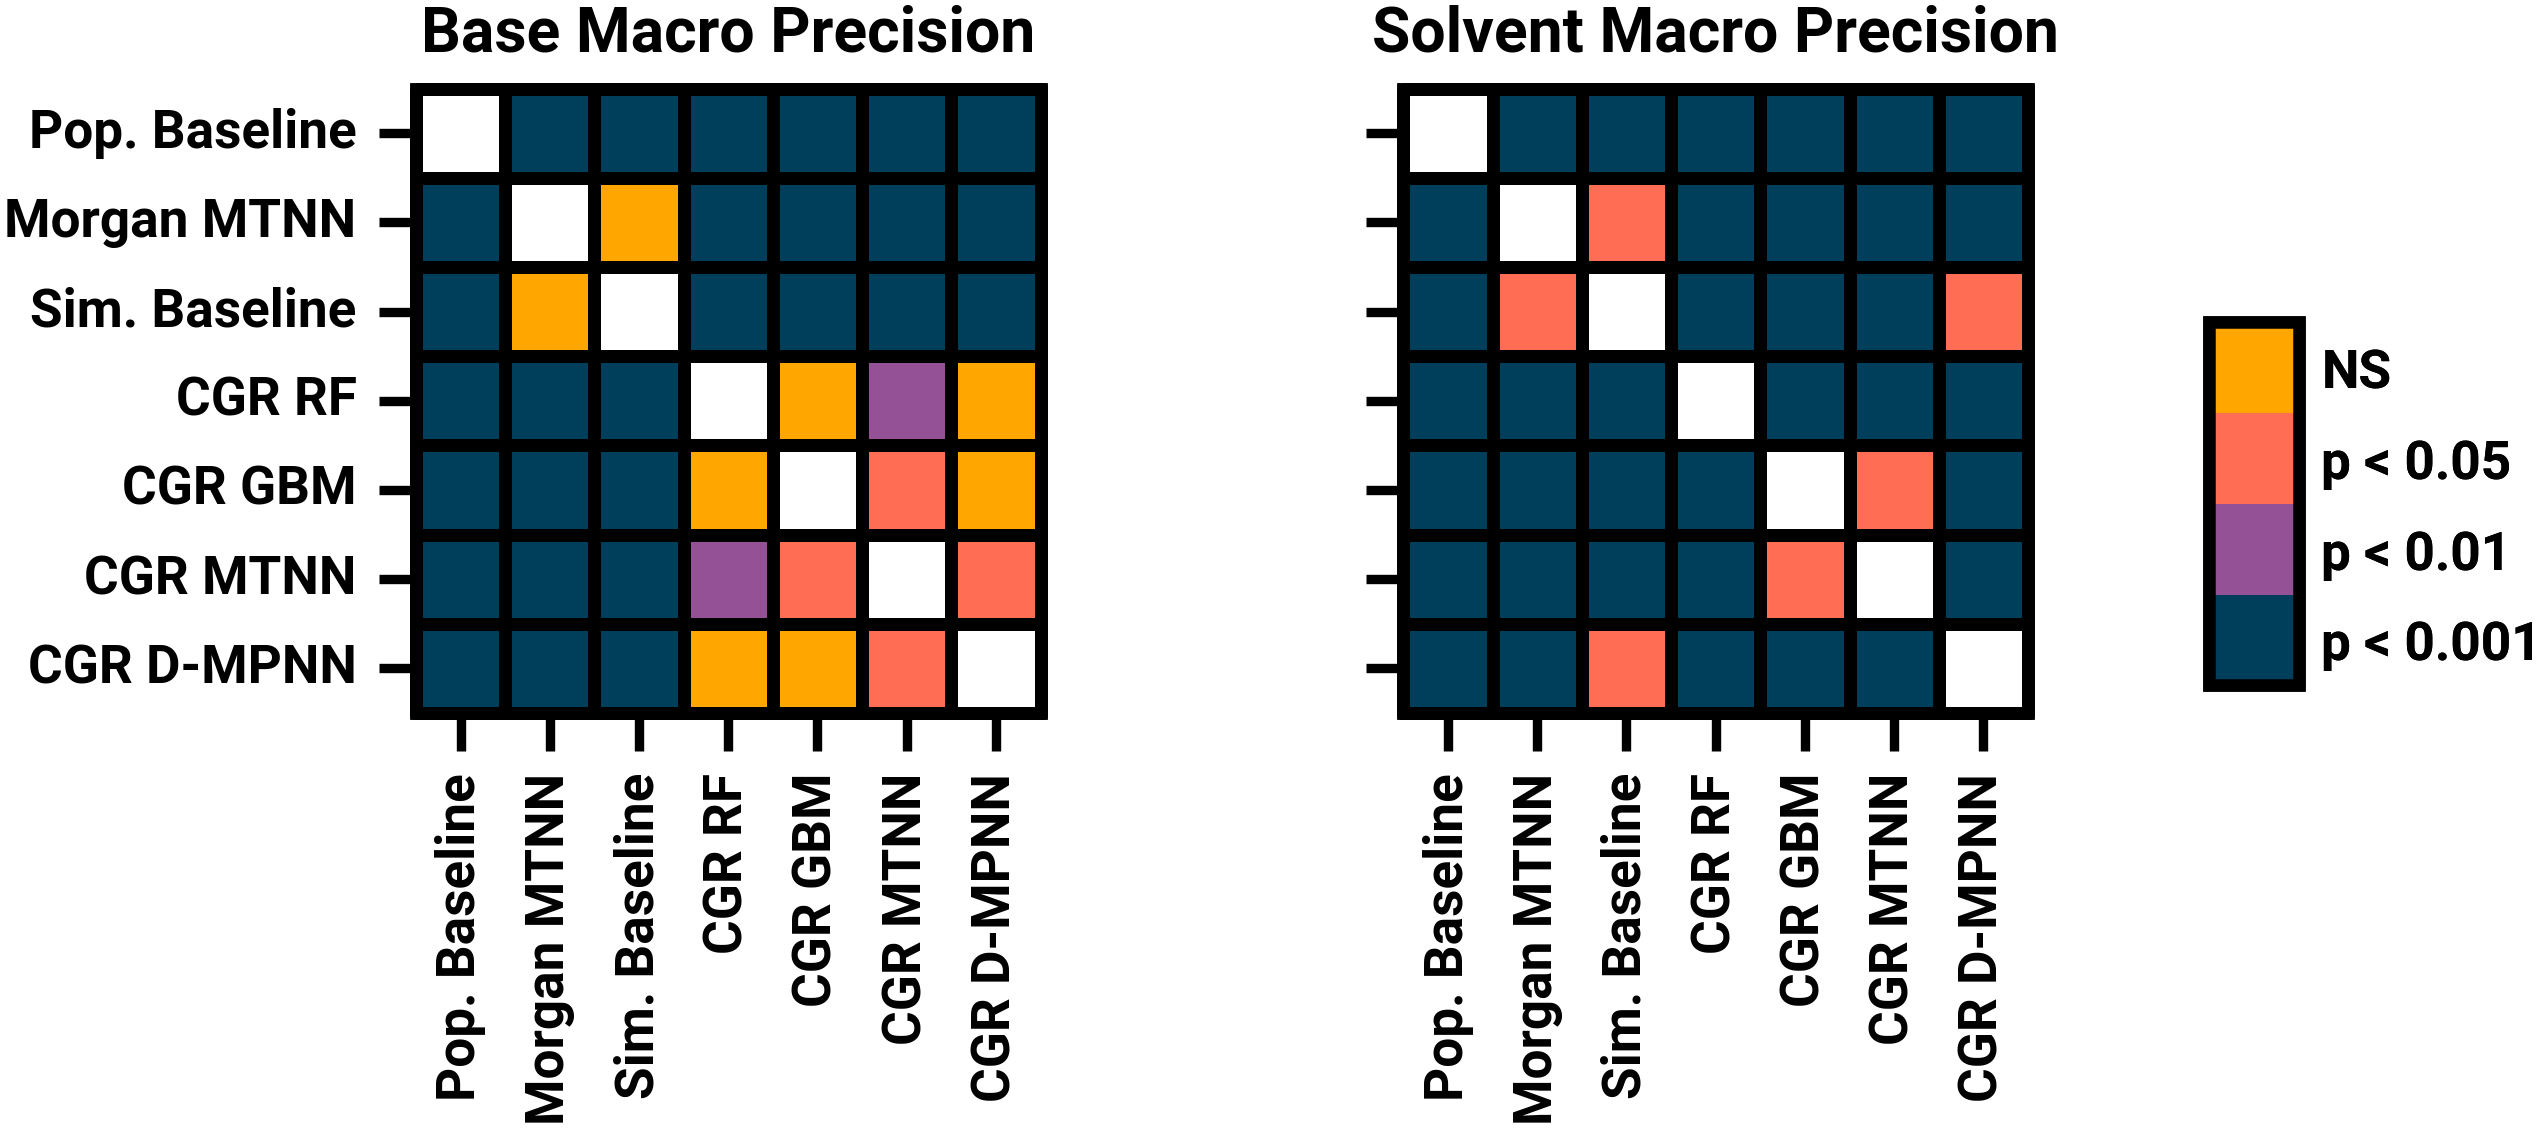

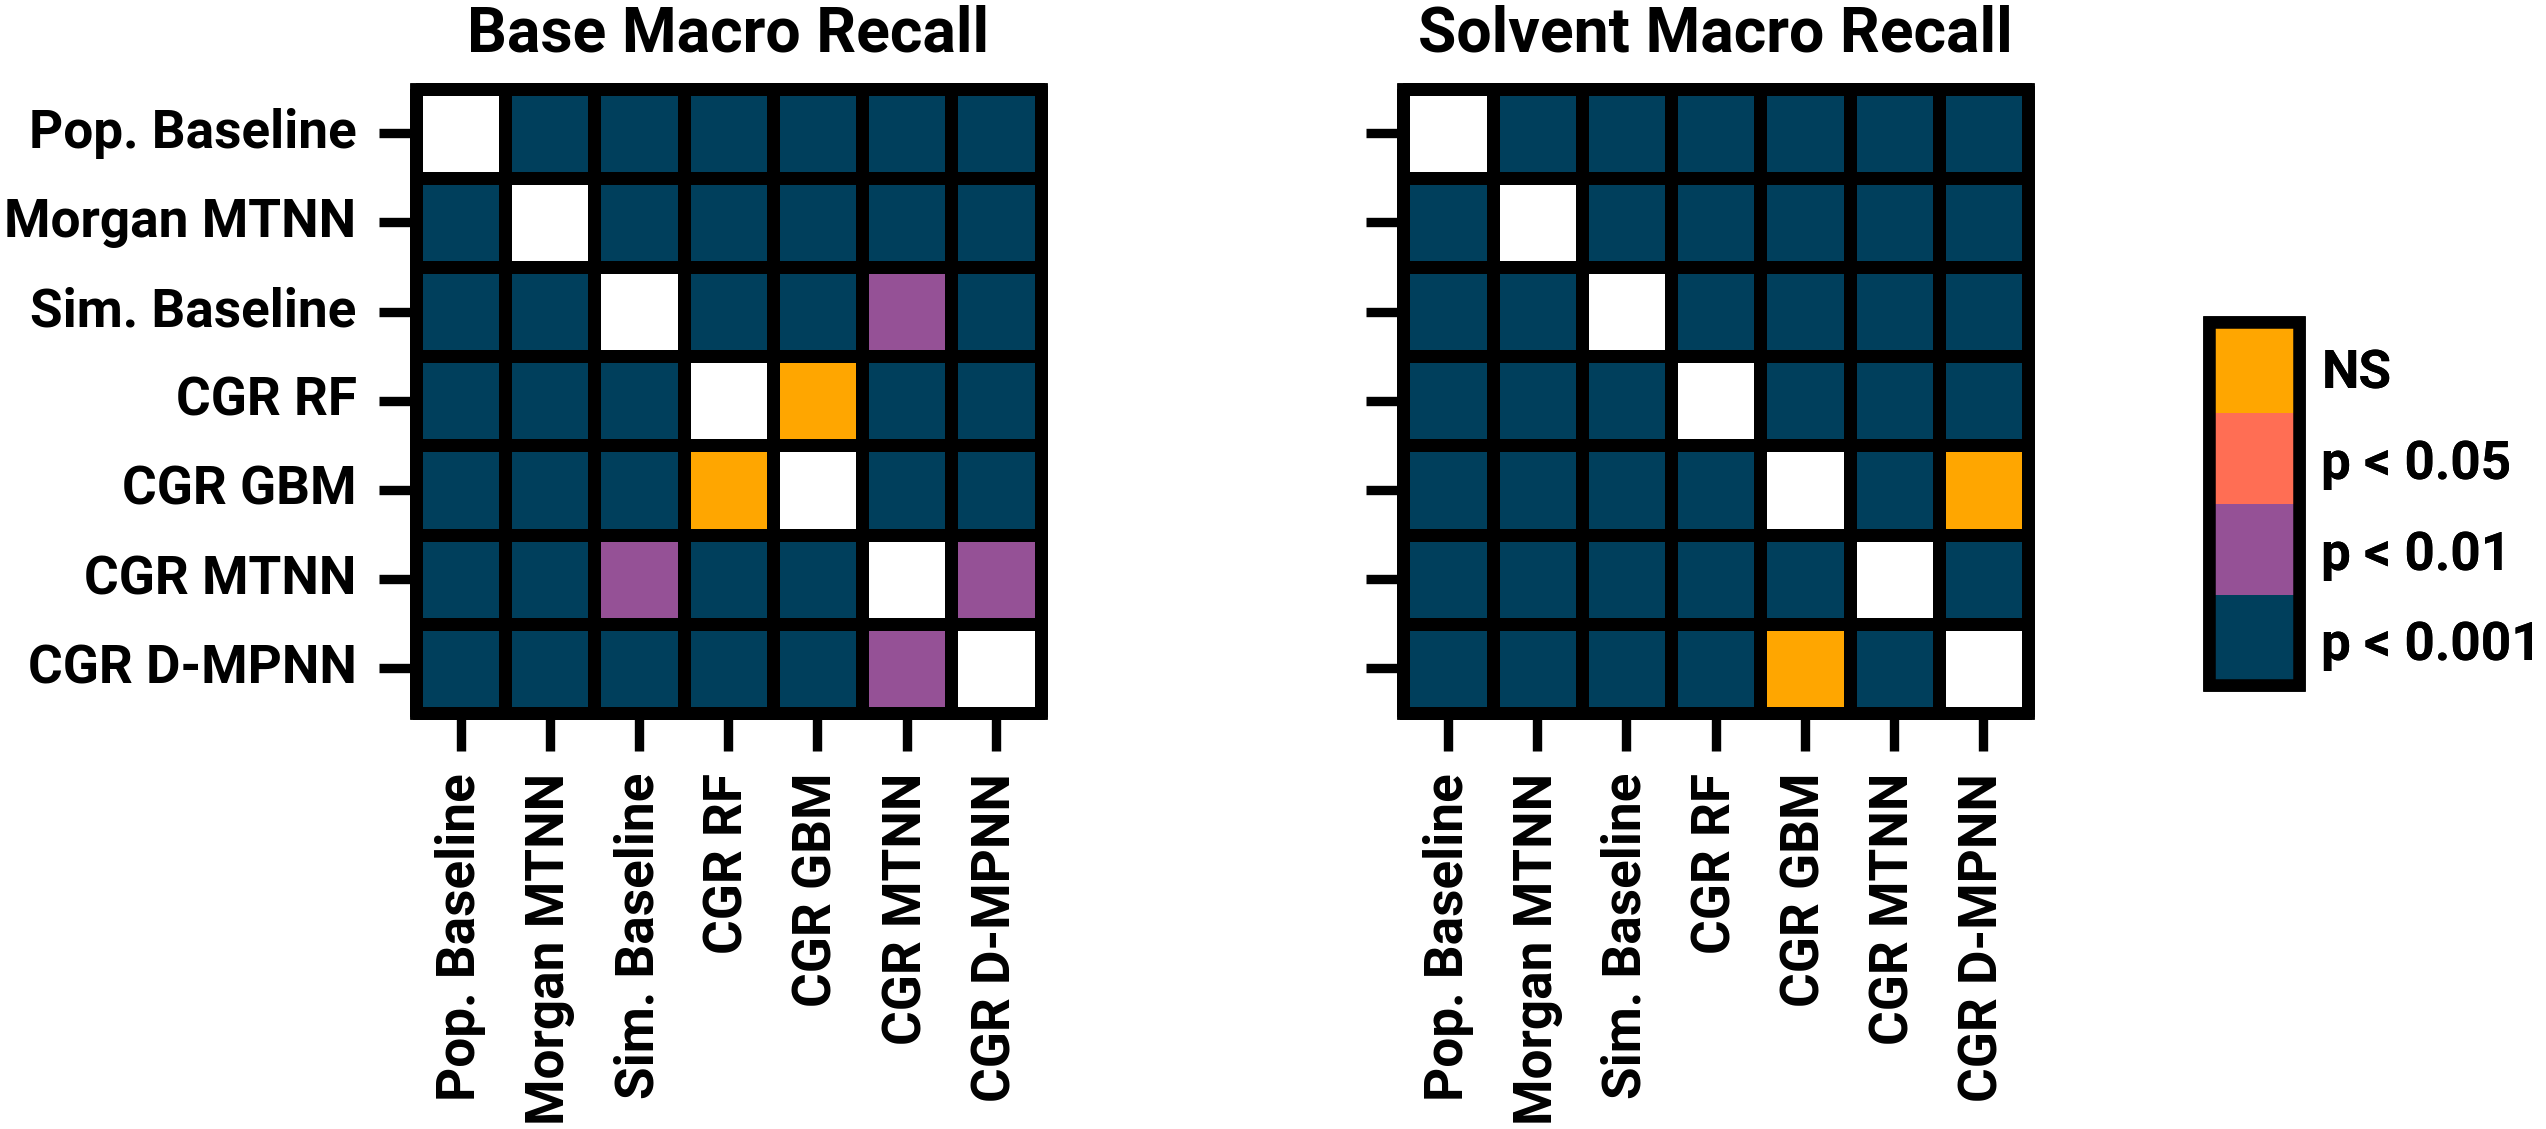

In [ ]:
os.makedirs(
    f"../reports/figures/{SOLVENT_CLASSIFICATION}_solvs/stat_analysis/metrics",
    exist_ok=True,
)

fig, axs = plt.subplots(
    ncols=len(reagent_types),
    nrows=len(metrics),
    figsize=(len(metrics) * 2.69, len(reagent_types) * 2.69),
)

custom_palette = (
    ["1"]
    + [SYNTHWAVE_PALETTE[-1]]
    + [SYNTHWAVE_PALETTE[i] for i in range(0, 5, 2)]
)

for i, metric in enumerate(metrics):
    fig2, axs2 = plt.subplots(
        nrows=1,
        ncols=len(reagent_types),
        figsize=(5, 2.69),
        sharey=True,
    )
    for j, reagent_type in enumerate(reagent_types):
        metric_name = (
            f"{reagent_type.title()} {metric.replace('_', ' ').title()}"
        )

        temp_df = combined_metrics_df.filter(
            (pl.col("reagent_type") == reagent_type)
            & (pl.col("metric") == metric)
        ).to_pandas()

        temp_df["cv"] = [
            (int(row["split"]) - 1) * 5 + int(row["fold"])
            for _, row in temp_df.iterrows()
        ]

        pivot_temp_df = temp_df.pivot(
            index="cv", columns="method", values="value"
        )

        pivot_temp_df = pivot_temp_df[
            [
                "Pop. Baseline",
                "Morgan MTNN",
                "Sim. Baseline",
                "CGR RF",
                "CGR GBM",
                "CGR MTNN",
                "CGR D-MPNN",
            ]
        ]

        pc = sp.posthoc_conover_friedman(
            pivot_temp_df,
            p_adjust="holm",
        )

        av_rank = (
            temp_df.groupby("cv")
            .value.rank(pct=True)
            .groupby(temp_df.method)
            .mean()
        )

        for k, axs_ in enumerate([axs, axs2]):
            if k == 0:
                idx = i, j
            else:
                idx = j
            axs_[idx].set_title(
                metric_name.title(),
                fontdict={"weight": "bold"},
            )

        sp_ax, sp_cb = sp.sign_plot(
            pc,
            ax=axs2[j],
            cmap=custom_palette,
            **{
                "linewidths": 2,
                "linecolor": "black",
                "clip_on": False,
                "square": True,
                "cbar_ax_bbox": [1, 0.4, 0.04, 0.3],
            },
        )

        sp.critical_difference_diagram(
            ranks=av_rank, sig_matrix=pc, ax=axs[i, j]
        )

        for spine in sp_ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(2)

        sp_cb.outline.set_color("black")
        sp_cb.outline.set_linewidth(2)

        sp_ax.tick_params(axis="both", which="both", direction="out")
        sp_ax.tick_params(axis="both", which="minor", length=0)

    fig2.savefig(
        f"../reports/figures/{SOLVENT_CLASSIFICATION}_solvs/stat_analysis/metrics/{metric}_sp.svg",
        bbox_inches="tight",
    )

fig.savefig(
    f"../reports/figures/{SOLVENT_CLASSIFICATION}_solvs/stat_analysis/metrics/cd.svg",
    bbox_inches="tight",
)